# Import Modules & Util Functions

In [1]:
import os
import sys
import glob
import re
import ast
import warnings
import time

import csv
import json
import pickle

import math
import random
import numpy as np
import scipy as sp
import datetime as dt
import pandas as pd
import swifter
from scipy.stats import gaussian_kde
from scipy.integrate import quad
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

import portion as P
import itertools as it
import copy
from tqdm.notebook import tqdm
from collections import namedtuple
from pprint import pprint
from pytictoc import TicToc

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from my_utils import *

# Configure display options
# pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)
%config InlineBackend.figure_format = 'retina'

# Set plot style
# plt.style.use('ggplot')


# Dual Radio Evaluation

In [2]:
class DEval:
    def __init__(self, filepaths, model_name='Test', model_suffix=None, sr_model_id=None, dr_model_id=None, load_path='.', save_path='.',
                 sp_columns=['type'], ts_column='Timestamp',
                 metrics=['dl_lost']):
        # Initialize instance variables
        self.filepaths = copy.deepcopy(filepaths)
        
        if sr_model_id is None:
            raise TypeError("請輸入SR模型編號")
        else:
            self.sr_model_id = sr_model_id
        
        if dr_model_id is None:
            raise TypeError("請輸入DR模型編號")
        else:
            self.dr_model_id = dr_model_id
        
        self.model_name = model_name
        self.save_path = save_path
        
        self.load_path = os.path.join(load_path, self.sr_model_id, 'models', self.model_name)
        print(self.load_path)
        with open(f'{self.load_path}_kde_models.pkl', 'rb') as f:
            self.kde_models = pickle.load(f)
        with open(f'{self.load_path}_hist_models.pkl', 'rb') as f:
            self.hist_models = pickle.load(f)
        with open(f'{self.load_path}_scope_models.pkl', 'rb') as f:
            self.scope_models = pickle.load(f)
        with open(f'{self.load_path}_plr_models.pkl', 'rb') as f:
            self.plr_models = pickle.load(f)
        with open(f'{self.load_path}_sr_prob_models.pkl', 'rb') as f:
            self.sr_prob_models = pickle.load(f)
            
        self.load_path = os.path.join(load_path, self.sr_model_id, self.dr_model_id, self.model_name)
        print(self.load_path)
        if model_suffix is None:
            print(f'{self.load_path}_dr_prob_models.pkl')
            with open(f'{self.load_path}_dr_prob_models.pkl', 'rb') as f:
                self.dr_prob_models = pickle.load(f)
        else:
            print(f'{self.load_path}_dr_prob_models_{model_suffix}.pkl')
            with open(f'{self.load_path}_dr_prob_models_{model_suffix}.pkl', 'rb') as f:
                self.dr_prob_models = pickle.load(f)
        self.model_suffix = model_suffix
        
        self.sp_columns = sp_columns[:]
        self.ts_column = ts_column
        self.metrics = metrics[:]
        
        _, _, _, self.figure_id = figure_identity()
        
        # Sample data
        self.LOSS_GT = []
        self.LOSS_EV = []
        self.LOSS_STD = []
        self.DEVICES = []
        self.TRACES = []
        
        # all records
        self.records = []

    @staticmethod
    def generate_random_boolean(probability_true):
        return random.random() < probability_true
    
    @staticmethod
    def interpolate(x, y, ratio=0.5):
        """
        Args:
            x, y (datetime.datetime): x < y
            ratio (float): a decimal numeral in a range [0, 1]; 0 means break at x, 1 means break at y.
        Returns:
            (datetime.datetime): breakpoint of interpolation
        """
        return x + (y - x) * ratio
    
    def hist_method(self, df, ho_df, mode_mets, mets, RATE_TYPE):
        scope = self.scope_models[mode_mets]
        hist_model = self.hist_models[mode_mets]
        prob_model = self.sr_prob_models[mode_mets]
        plr_model = self.plr_models[mode_mets]
        
        this_df = df.copy()
        for i, row in ho_df.iterrows():
            prior_row = ho_df.iloc[i-1] if i != 0 else None
            post_row = ho_df.iloc[i+1] if i != len(ho_df) - 1 else None

            # Peek the next event to avoid HO overlapping with handoverFailure (skip!!)
            if i != len(ho_df) - 1 and pd.notna(row.end) and row.end > post_row.start:
                # print('Overlapping event occurs!!')
                # print(i, row['start'], row['end'], row['type'], row['cause'])
                # print(i+1, post_row['start'], post_row['end'], post_row['type'], post_row['cause'])
                continue
            
            # Set prior event if the prior loop is skipped
            if i != 0 and pd.notna(prior_row.end) and prior_row.end > row.start:
                prior_row = ho_df.iloc[i-2] if i > 1 else None
            
            # Basic information of the current row
            tag = '_'.join([s for s in row[self.sp_columns] if pd.notna(s)])  # specific column name
            start_ts, end_ts = row['start'], row['end']  # handover start/end time
            interruption_time = (end_ts - start_ts).total_seconds() if pd.notna(end_ts) else 0  # handover interruption time
            
            # Set simple left/right bounds
            current_left_bound = start_ts + pd.Timedelta(seconds=(scope[tag][0]))
            current_right_bound = start_ts + pd.Timedelta(seconds=(scope[tag][1]))
            
            # Set left/right bounds to avoid event overlapping with each other
            if prior_row is not None:
                prior_tag = '_'.join([s for s in prior_row[self.sp_columns] if pd.notna(s)])
                prior_right_bound = prior_row['start'] + pd.Timedelta(seconds=(scope[prior_tag][1]))
                if pd.notna(prior_row['end']):
                    left_bound = min(max(current_left_bound, DEval.interpolate(prior_right_bound, current_left_bound), prior_row['end']), start_ts)
                else:
                    left_bound = min(max(current_left_bound, DEval.interpolate(prior_right_bound, current_left_bound), prior_row['start']), start_ts)
            else:
                left_bound = current_left_bound
            
            if post_row is not None:
                post_tag = '_'.join([s for s in post_row[self.sp_columns] if pd.notna(s)])
                post_left_bound = post_row['start'] + pd.Timedelta(seconds=(scope[post_tag][0]))
                if pd.notna(end_ts):
                    right_bound = max(min(current_right_bound, DEval.interpolate(current_right_bound, post_left_bound), post_row['start']), end_ts)
                else:
                    right_bound = max(min(current_right_bound, DEval.interpolate(current_right_bound, post_left_bound), post_row['start']), start_ts)
            else:
                right_bound = current_right_bound
            
            interval = P.closed(left_bound, right_bound)
            
            # Concatenate PLR from mapping list
            current_df = this_df[this_df['Timestamp'] < interval.upper].copy()
            plr_mapping = hist_model[tag].copy()
            
            current_df[f'relative_time'] = (current_df['Timestamp'] - start_ts).dt.total_seconds()
            current_df[f'window_id'] = ((current_df[f'relative_time'] + 0.005) // 0.01) * 0.01
            
            trigger_probability = prob_model[tag]
            
            if plr_mapping.empty:
                tmp = current_df.copy().rename(columns={mets: f'{mets}_x'})
            else:
                tmp = pd.merge(current_df, plr_mapping, on='window_id', how='left')
                tmp[RATE_TYPE] = tmp[RATE_TYPE].fillna(0)
                
                if not DEval.generate_random_boolean(trigger_probability):
                    tmp[RATE_TYPE] = 0
            
            tmp['type'] = tag
            
            if i == 0:
                answer = tmp.copy()
            else:
                answer = pd.concat([answer, tmp], axis=0)
            
            # Update dataframe to accelerate the speed
            this_df = this_df[this_df[self.ts_column] >= interval.upper].copy()
        
        answer = pd.concat([answer, this_df], axis=0)
        
        # Consider stable duration
        stable_df = answer[answer['tx_count'].isnull()].copy()[['seq', 'lost_x', 'excl', 'Timestamp']].rename(columns={'lost_x': 'lost'})

        stable_df['Timestamp_sec'] = stable_df['Timestamp'].dt.floor('S')
        stable_df['relative_time'] = (stable_df['Timestamp'] - stable_df['Timestamp_sec']).dt.total_seconds() - 0.5
        stable_df['window_id'] = ((stable_df['relative_time'] + 0.01 / 2) // 0.01) * 0.01

        plr_mapping = hist_model['Stable'].copy()        
        stable_df = pd.merge(stable_df, plr_mapping, on='window_id', how='left').rename(columns={'PLR': 'PLR_if_trigger'})
        trigger_prob_mapping = stable_df[~stable_df['Timestamp_sec'].duplicated()].reset_index(drop=True)[['Timestamp_sec']]
        
        trigger_probability = prob_model['Stable']
        random_bool_array = [DEval.generate_random_boolean(trigger_probability) for _ in range(len(trigger_prob_mapping))]
        trigger_prob_mapping['trigger'] = random_bool_array

        stable_df = pd.merge(stable_df, trigger_prob_mapping, on='Timestamp_sec', how='left')
        stable_df['PLR'] = stable_df['PLR_if_trigger'] * stable_df['trigger']
        
        stable_df['type'] = 'Stable'

        del stable_df['Timestamp_sec'], stable_df['PLR_if_trigger'], stable_df['trigger']
        
        answer = answer[answer['tx_count'].notnull()].copy()
        
        answer = pd.concat([answer, stable_df], axis=0)
        answer = answer.sort_values(by='Timestamp').reset_index(drop=True)
        answer['PLR'] = answer['PLR'] / 100
        answer['Y'] = answer['PLR'].apply(DEval.generate_random_boolean)
        
        eval_value = answer['Y'].mean() * 100
        ground_value = df['lost'].mean() * 100
        
        answer = pd.concat([answer[['seq', 'Timestamp', 'type', 'relative_time', 'window_id']],
                            df[['lost']],
                            answer[[RATE_TYPE, 'Y']]], axis=1)
        
        return answer, eval_value, ground_value
    
    
    def setup_profile(self, df, ho_df, df2, scope):
        
        this_df = df2.copy()
        this_df = this_df[this_df['Y']].copy().reset_index(drop=True)
        
        df['anchor_type'] = 'Stable'
        df['anchor_state'] = 0
        for i, row in ho_df.iterrows():
            prior_row = ho_df.iloc[i-1] if i != 0 else None
            post_row = ho_df.iloc[i+1] if i != len(ho_df) - 1 else None

            # Peek the next event to avoid HO overlapping with handoverFailure (skip!!)
            if i != len(ho_df) - 1 and pd.notna(row.end) and row.end > post_row.start:
                # print('Overlapping event occurs!!')
                # print(i, row['start'], row['end'], row['type'], row['cause'])
                # print(i+1, post_row['start'], post_row['end'], post_row['type'], post_row['cause'])
                continue
            
            # Set prior event if the prior loop is skipped
            if i != 0 and pd.notna(prior_row.end) and prior_row.end > row.start:
                prior_row = ho_df.iloc[i-2] if i > 1 else None
            
            # Basic information of the current row
            tag = '_'.join([s for s in row[self.sp_columns] if pd.notna(s)])  # specific column name
            start_ts, end_ts = row['start'], row['end']  # handover start/end time
            interruption_time = (end_ts - start_ts).total_seconds() if pd.notna(end_ts) else 0  # handover interruption time
            
            # Set simple left/right bounds
            current_left_bound = start_ts + pd.Timedelta(seconds=(scope[tag][0]))
            current_right_bound = start_ts + pd.Timedelta(seconds=(scope[tag][1]))
            
            # Set left/right bounds to avoid event overlapping with each other
            if prior_row is not None:
                prior_tag = '_'.join([s for s in prior_row[self.sp_columns] if pd.notna(s)])
                prior_right_bound = prior_row['start'] + pd.Timedelta(seconds=(scope[prior_tag][1]))
                if pd.notna(prior_row['end']):
                    left_bound = min(max(current_left_bound, DEval.interpolate(prior_right_bound, current_left_bound), prior_row['end']), start_ts)
                else:
                    left_bound = min(max(current_left_bound, DEval.interpolate(prior_right_bound, current_left_bound), prior_row['start']), start_ts)
            else:
                left_bound = current_left_bound
            
            if post_row is not None:
                post_tag = '_'.join([s for s in post_row[self.sp_columns] if pd.notna(s)])
                post_left_bound = post_row['start'] + pd.Timedelta(seconds=(scope[post_tag][0]))
                if pd.notna(end_ts):
                    right_bound = max(min(current_right_bound, DEval.interpolate(current_right_bound, post_left_bound), post_row['start']), end_ts)
                else:
                    right_bound = max(min(current_right_bound, DEval.interpolate(current_right_bound, post_left_bound), post_row['start']), start_ts)
            else:
                right_bound = current_right_bound
            
            interval = P.closed(left_bound, right_bound)
            
            df.loc[(df['start'] >= interval.lower) & (df['start'] < interval.upper), 'anchor_type'] = tag
            
            if not this_df[(this_df['Timestamp'] >= interval.lower) & (this_df['Timestamp'] < interval.upper)].empty:
                df.loc[(df['start'] >= interval.lower) & (df['start'] < interval.upper), 'anchor_state'] = 1
                
            # Update dataframe to accelerate the speed
            this_df = this_df[this_df[self.ts_column] >= interval.upper].copy()
            
        return df
    
    
    def hist_method_dual(self, df, ho_df, mode_mets, mets, RATE_TYPE):
        scope = self.scope_models[mode_mets]
        hist_model = self.hist_models[mode_mets]
        dr_prob_model = self.dr_prob_models[mode_mets]
        
        this_df = df.copy()
        for i, row in ho_df.iterrows():
            prior_row = ho_df.iloc[i-1] if i != 0 else None
            post_row = ho_df.iloc[i+1] if i != len(ho_df) - 1 else None

            # Peek the next event to avoid HO overlapping with handoverFailure (skip!!)
            if i != len(ho_df) - 1 and pd.notna(row.end) and row.end > post_row.start:
                # print('Overlapping event occurs!!')
                # print(i, row['start'], row['end'], row['type'], row['cause'])
                # print(i+1, post_row['start'], post_row['end'], post_row['type'], post_row['cause'])
                continue
            
            # Set prior event if the prior loop is skipped
            if i != 0 and pd.notna(prior_row.end) and prior_row.end > row.start:
                prior_row = ho_df.iloc[i-2] if i > 1 else None
            
            # Basic information of the current row
            tag = '_'.join([s for s in row[self.sp_columns] if pd.notna(s)])  # specific column name
            start_ts, end_ts = row['start'], row['end']  # handover start/end time
            interruption_time = (end_ts - start_ts).total_seconds() if pd.notna(end_ts) else 0  # handover interruption time
            
            # Set simple left/right bounds
            current_left_bound = start_ts + pd.Timedelta(seconds=(scope[tag][0]))
            current_right_bound = start_ts + pd.Timedelta(seconds=(scope[tag][1]))
            
            # Set left/right bounds to avoid event overlapping with each other
            if prior_row is not None:
                prior_tag = '_'.join([s for s in prior_row[self.sp_columns] if pd.notna(s)])
                prior_right_bound = prior_row['start'] + pd.Timedelta(seconds=(scope[prior_tag][1]))
                if pd.notna(prior_row['end']):
                    left_bound = min(max(current_left_bound, DEval.interpolate(prior_right_bound, current_left_bound), prior_row['end']), start_ts)
                else:
                    left_bound = min(max(current_left_bound, DEval.interpolate(prior_right_bound, current_left_bound), prior_row['start']), start_ts)
            else:
                left_bound = current_left_bound
            
            if post_row is not None:
                post_tag = '_'.join([s for s in post_row[self.sp_columns] if pd.notna(s)])
                post_left_bound = post_row['start'] + pd.Timedelta(seconds=(scope[post_tag][0]))
                if pd.notna(end_ts):
                    right_bound = max(min(current_right_bound, DEval.interpolate(current_right_bound, post_left_bound), post_row['start']), end_ts)
                else:
                    right_bound = max(min(current_right_bound, DEval.interpolate(current_right_bound, post_left_bound), post_row['start']), start_ts)
            else:
                right_bound = current_right_bound
            
            interval = P.closed(left_bound, right_bound)
            
            # Concatenate PLR from mapping list
            current_df = this_df[this_df['Timestamp'] < interval.upper].copy()
            plr_mapping = hist_model[tag].copy()
            
            current_df[f'relative_time'] = (current_df['Timestamp'] - start_ts).dt.total_seconds()
            current_df[f'window_id'] = ((current_df[f'relative_time'] + 0.005) // 0.01) * 0.01
            
            anchor_tag = row['anchor_type']
            anchor_state = row['anchor_state']
            
            if anchor_state == 1:
                trigger_probability = dr_prob_model[(anchor_tag, tag)][0]
            else:
                trigger_probability = dr_prob_model[(anchor_tag, tag)][1]
            
            if plr_mapping.empty:
                tmp = current_df.copy().rename(columns={mets: f'{mets}_x'})
            else:
                tmp = pd.merge(current_df, plr_mapping, on='window_id', how='left')
                tmp[RATE_TYPE] = tmp[RATE_TYPE].fillna(0)
                
                if not DEval.generate_random_boolean(trigger_probability):
                    tmp[RATE_TYPE] = 0
            
            tmp['anchor_type'] = anchor_tag
            tmp['anchor_state'] = anchor_state
            tmp['type'] = tag
            
            if i == 0:
                answer = tmp.copy()
            else:
                answer = pd.concat([answer, tmp], axis=0)
            
            # Update dataframe to accelerate the speed
            this_df = this_df[this_df[self.ts_column] >= interval.upper].copy()
        
        answer = pd.concat([answer, this_df], axis=0)
        # display(answer)
        
        # Consider stable duration
        stable_df = answer[answer['tx_count'].isnull()].copy()[['seq', 'lost_x', 'excl', 'Timestamp']].rename(columns={'lost_x': 'lost'})

        stable_df['Timestamp_sec'] = stable_df['Timestamp'].dt.floor('S')
        stable_df['relative_time'] = (stable_df['Timestamp'] - stable_df['Timestamp_sec']).dt.total_seconds() - 0.5
        stable_df['window_id'] = ((stable_df['relative_time'] + 0.01 / 2) // 0.01) * 0.01

        plr_mapping = hist_model['Stable'].copy()        
        stable_df = pd.merge(stable_df, plr_mapping, on='window_id', how='left').rename(columns={'PLR': 'PLR_if_trigger'})
        trigger_prob_mapping = stable_df[~stable_df['Timestamp_sec'].duplicated()].reset_index(drop=True)[['Timestamp_sec']]
        
        trigger_probability = dr_prob_model[('Stable', 'Stable')][0]
        
        # if anchor_state == 1:
        #     trigger_probability = dr_prob_model[(anchor_tag, tag)][0]
        # else:
        #     trigger_probability = dr_prob_model[(anchor_tag, tag)][1]
                
        random_bool_array = [DEval.generate_random_boolean(trigger_probability) for _ in range(len(trigger_prob_mapping))]
        trigger_prob_mapping['trigger'] = random_bool_array

        stable_df = pd.merge(stable_df, trigger_prob_mapping, on='Timestamp_sec', how='left')
        stable_df['PLR'] = stable_df['PLR_if_trigger'] * stable_df['trigger']
        
        # stable_df['type'] = 'Stable'
        stable_df['anchor_type'] = 'Stable'
        stable_df['anchor_state'] = 0
        stable_df['type'] = 'Stable'

        del stable_df['Timestamp_sec'], stable_df['PLR_if_trigger'], stable_df['trigger']
        
        answer = answer[answer['tx_count'].notnull()].copy()
        
        answer = pd.concat([answer, stable_df], axis=0)
        answer = answer.sort_values(by='Timestamp').reset_index(drop=True)
        answer['PLR'] = answer['PLR'] / 100
        answer['Y'] = answer['PLR'].apply(DEval.generate_random_boolean)
        
        eval_value = answer['Y'].mean() * 100
        ground_value = df['lost'].mean() * 100
        
        answer = pd.concat([answer[['seq', 'Timestamp', 'anchor_type', 'anchor_state', 'type', 'relative_time', 'window_id']],
                            df[['lost']],
                            answer[[RATE_TYPE, 'Y']]], axis=1)

        return answer, eval_value, ground_value

        # return answer, eval_value, ground_value
        
        # # Consider stable duration
        # stable_df = answer[answer['tx_count'].isnull()].copy()[['seq', 'lost_x', 'excl', 'Timestamp']].rename(columns={'lost_x': 'lost'})

        # stable_df['Timestamp_sec'] = stable_df['Timestamp'].dt.floor('S')
        # stable_df['relative_time'] = (stable_df['Timestamp'] - stable_df['Timestamp_sec']).dt.total_seconds() - 0.5
        # stable_df['window_id'] = ((stable_df['relative_time'] + 0.01 / 2) // 0.01) * 0.01

        # plr_mapping = hist_model['Stable'].copy()
        # stable_df = pd.merge(stable_df, plr_mapping, on='window_id', how='left').rename(columns={'PLR': 'PLR_trig'})

        # trig_p_mapping = stable_df[~stable_df['Timestamp_sec'].duplicated()].reset_index(drop=True)
        
        # triggered_p = dr_prob_model[('Stable', 'Stable')][0]
        
        # random_bool_array = [DEval.generate_random_boolean(triggered_p) for _ in range(len(trig_p_mapping))]
        # trig_p_mapping['trigger'] = random_bool_array
        # trig_p_mapping = trig_p_mapping[['Timestamp_sec', 'trigger']]

        # stable_df = pd.merge(stable_df, trig_p_mapping, on='Timestamp_sec', how='left')
        # stable_df['PLR'] = stable_df['PLR_trig'] * stable_df['trigger']

        # del stable_df['Timestamp_sec'], stable_df['PLR_trig'], stable_df['trigger']
        
        # answer = answer[answer['tx_count'].notnull()].copy()
        # # display(answer)
        
        # answer = pd.concat([answer, stable_df], axis=0)
        # answer = answer.sort_values(by='Timestamp').reset_index(drop=True)
        # answer['PLR'] = answer['PLR'] / 100
        # answer['Y'] = answer['PLR'].apply(DEval.generate_random_boolean)
        
        # eval_value = answer['Y'].mean() * 100
        # ground_value = df['lost'].mean() * 100
    
    
    def run_hist_method(self, N=3):
        scope = self.scope_models['dl_lost']
        n = len(self.filepaths)
        for mode_mets in ['dl_lost']:
            for i, filepath in enumerate(self.filepaths):
                
                # if i > 35:
                #     break
                
                # if i > 0:
                #     break
                
                print(f'{i}/{n}', filepath[0][0]); print(f'{i}/{n}', filepath[0][1]); print(f'{i}/{n}', filepath[0][2])
                print(f'{i}/{n}', filepath[1][0]); print(f'{i}/{n}', filepath[1][1]); print(f'{i}/{n}', filepath[1][2])
                    
                ho_df1 = pd.read_csv(filepath[0][0], parse_dates=['start', 'end'])
                ho_df2 = pd.read_csv(filepath[1][0], parse_dates=['start', 'end'])
                
                if ho_df1.empty or ho_df2.empty:
                    print('******** Empty RRC Data ********')
                    continue
                
                # df, ho_df, empty_data = data_aligner(df, ho_df)
                
                df1 = pd.read_csv(filepath[0][1], parse_dates=['Timestamp'])[['seq', 'Timestamp', 'lost', 'excl', 'latency']]
                df2 = pd.read_csv(filepath[1][1], parse_dates=['Timestamp'])[['seq', 'Timestamp', 'lost', 'excl', 'latency']]
                df1, ho_df1, empty_data1 = data_aligner(df1, ho_df1)
                df2, ho_df2, empty_data2 = data_aligner(df2, ho_df2)
                
                if empty_data1 or empty_data2:
                    print('******** Empty RRC Data ********')
                    continue
                
                df = pd.merge(df1, df2, on='seq', how='inner').reset_index(drop=True)
                
                df1 = df[['seq', 'Timestamp_x', 'lost_x', 'excl_x', 'latency_x']].rename(columns={'Timestamp_x': 'Timestamp', 'lost_x': 'lost', 'excl_x': 'excl', 'latency_x': 'latency'})
                df2 = df[['seq', 'Timestamp_y', 'lost_y', 'excl_y', 'latency_y']].rename(columns={'Timestamp_y': 'Timestamp', 'lost_y': 'lost', 'excl_y': 'excl', 'latency_y': 'latency'})
                
                loss_rate_list = []
                answer = None
                for iter_round in tqdm(range(N), ncols=1000):
                    ans1, eval_value1, ground_value1 = eval.hist_method(df1, ho_df1, mode_mets='dl_lost', mets='lost', RATE_TYPE='PLR')
                    # display(answer1)
                    
                    # setup_profile
                    # ho_df1 = self.setup_profile(ho_df1, ho_df2, df2, scope)
                    avatar_ho_df2 = self.setup_profile(ho_df2.copy(), ho_df1, ans1, scope)
                    
                    # display(avatar_ho_df2)
                    
                    ans2, eval_value2, ground_value2 = eval.hist_method_dual(df2, avatar_ho_df2, mode_mets='dl_lost', mets='lost', RATE_TYPE='PLR')
                    
                    # display(ans1)
                    # display(ans2)
                    # display(answer2)
                    
                    ans = pd.merge(ans1, ans2, on='seq', how='inner').reset_index(drop=True)
                    ans['lost'] = (ans['lost_x']) & (ans['lost_y'])
                    ans['Y'] = (ans['Y_x']) & (ans['Y_y'])
                    ans = ans[['seq', 'Timestamp_x', 'Timestamp_y', 'type_x', 'anchor_type', 'anchor_state', 'type_y', 'relative_time_x', 'window_id_x', 'relative_time_y', 'window_id_y', 'lost_x', 'lost_y', 'lost', 'PLR_x', 'Y_x', 'PLR_y', 'Y_y', 'Y']]
                    
                    # display(ans)
                    
                    handle = (ans1['Y']) & (ans2['Y'])
                    eval_value = handle.mean() * 100
                    # print('eval:', eval_value, len(handle))
                    
                    handle = (df1['lost']) & (df2['lost'])
                    ground_value = handle.mean() * 100
                    # print('ground:', ground_value, len(handle))
                    
                    if answer is None:
                        answer = ans.copy()
                        answer = answer.rename(columns={'PLR_x': f'PLR_x_0', 'Y_x': f'Y_x_0', 'PLR_y': f'PLR_y_0', 'Y_y': f'Y_y_0', 'Y': f'Y_0'})
                    else:
                        answer = pd.concat([answer, ans[['PLR_x', 'Y_x', 'PLR_y', 'Y_y', 'Y']]], axis=1)
                        answer = answer.rename(columns={'PLR_x': f'PLR_x_{iter_round}', 'Y_x': f'Y_x_{iter_round}', 'PLR_y': f'PLR_y_{iter_round}', 'Y_y': f'Y_y_{iter_round}', 'Y': f'Y_{iter_round}'})
                    
                    loss_rate_list.append(eval_value)
                
                # display(answer)
        
                mean_value = np.mean(loss_rate_list)
                std_deviation = np.std(loss_rate_list)

                # print()
                # print("Mean:", mean_value)
                # print("Standard Deviation:", std_deviation)
                # print("Ground Truth:", ground_value)
                
                self.LOSS_GT.append(ground_value)
                self.LOSS_EV.append(mean_value)
                self.LOSS_STD.append(std_deviation)
                
                path1 = filepath[0][1]
                path2 = filepath[1][1]
                
                error = mean_value - ground_value
                self.records.append((mean_value, std_deviation, ground_value, error, path1, path2))

                def find_sm_label(path):
                    # 找到 "sm" 的位置
                    sm_index = path.index("sm")
                    # 从 "sm" 的位置开始找到下一个斜杠 "/"
                    next_slash_index = path.index("/", sm_index)
                    # 截取 "sm00" 标签
                    # sm_label = path[sm_index:next_slash_index]
                    sm_label = path[sm_index+2:next_slash_index]
                    # print("截取的标签为:", sm_label)
                    return sm_label
                
                self.DEVICES.append(find_sm_label(path1)+'+'+find_sm_label(path2))
                
                def find_tr_label(path):
                    # 找到 "sm" 的位置
                    sm_index = path.index("#")
                    # 从 "sm" 的位置开始找到下一个斜杠 "/"
                    next_slash_index = path.index("/", sm_index)
                    # 截取 "sm00" 标签
                    # sm_label = path[sm_index:next_slash_index]
                    sm_label = path[sm_index+1:next_slash_index]
                    # print("截取的标签为:", sm_label)
                    return sm_label
                
                self.TRACES.append(find_tr_label(path1)+'+'+find_tr_label(path2))
                
                if self.model_suffix is None:
                    save_path = os.path.join(self.save_path, self.sr_model_id, self.dr_model_id, 'results', self.figure_id)
                else:
                    save_path = os.path.join(self.save_path, self.sr_model_id, self.dr_model_id, 'results', f'{self.figure_id}_{self.model_suffix}')
                    
                if not os.path.isdir(save_path):
                    os.makedirs(save_path)
                
                save_path = os.path.join(save_path, path1.replace('/', '\\')[:-4]+path2.replace('/', '\\'))
                print(save_path)
                answer.to_csv(save_path, index=False)
    
    
    def plot(self, save_name='plot_example', save_path='.'):
        # Sample data
        x = self.LOSS_GT.copy()
        y = self.LOSS_EV.copy()

        # Standard deviations for error bars
        y_error = self.LOSS_STD.copy()

        # Create figure and axes
        fig, ax = plt.subplots(figsize=(6, 4))

        # Scatter plot with error bars and horizontal caps
        ax.errorbar(x, y, yerr=y_error, linestyle='None', marker='o', color='tab:blue', capsize=5)
        ax.scatter([], [], linestyle='None', marker='o', color='tab:blue', label='Data Points')

        # Regression line
        coefficients = np.polyfit(x, y, 1)
        regression_line = np.poly1d(coefficients)
        ax.plot(ax.get_xlim(), regression_line(ax.get_xlim()), linestyle='--', linewidth=1.1, color='tab:blue', label='Regression Line')

        # Annotate the slope of the regression line
        # slope_annotation = f'Slope: {coefficients[0]:.2f}'
        # ax.annotate(slope_annotation, xy=(0.5, 0.85), xycoords='axes fraction', fontsize=10, fontstyle='italic', fontweight='bold', color='tab:blue')

        # Annotate MSE From the regression line
        y_pred = regression_line(x)
        # mse = mean_squared_error(y, y_pred)
        mse = np.sqrt(mean_squared_error(x, y))
        mse_rate = mse / np.mean(x) * 100
        slope_annotation = f'RMSE: {mse:.3f} ({mse_rate:.1f} %)'
        ax.annotate(slope_annotation, xy=(0.5, 0.85), xycoords='axes fraction', fontsize=10, fontstyle='italic', fontweight='bold', color='tab:blue')

        # 45-Degree Line
        ax.plot(ax.get_xlim(), ax.get_xlim(), linestyle='-', linewidth=1.1, color='tab:pink', label='45-Degree Line', alpha=0.9)
        # ax.plot(ax.get_xlim(), 1.1 * ax.get_xlim(), linestyle='-', linewidth=1.1, color='tab:pink', label='45-Degree Line', alpha=0.9)
        # ax.plot(ax.get_xlim(), 0.9 * ax.get_xlim(), linestyle='-', linewidth=1.1, color='tab:pink', label='45-Degree Line', alpha=0.9)
        
        # 获取 x 的边界
        x_limits = ax.get_xlim()

        # 创建 x 值范围
        x_values = np.linspace(x_limits[0], x_limits[1], 100)  # 使用 x 的边界值作为范围

        # 计算 y = 1.1x 和 y = 0.9x 的值
        y_upper = 1.1 * x_values
        y_lower = 0.9 * x_values

        # 绘制 y = 1.1x 和 y = 0.9x 线
        ax.plot(x_values, y_upper, linestyle='-', linewidth=1.1, color='tab:orange')
        ax.plot(x_values, y_lower, linestyle='-', linewidth=1.1, color='tab:orange')

        # 在两条线之间填充颜色
        ax.fill_between(x_values, y_lower, y_upper, color='tab:orange', alpha=0.3)

        # Set labels and title
        ax.set_xlabel('PLR Ground Truth')
        ax.set_ylabel('PLR Evaluated')
        # ax.set_title('A Profile Evaluate 9 Traces From A5 Data: Single')

        for i, sm_label in enumerate(self.DEVICES):
            ax.annotate(sm_label, xy=(x[i], y[i]))
            
        # Add a legend
        ax.legend()
        
        save_path = os.path.join(save_path, self.sr_model_id, self.dr_model_id, 'figures')
        if not os.path.isdir(save_path):
            os.makedirs(save_path)
        
        if self.model_suffix is not None:
            save_name = f'{save_name}_{self.model_suffix}'
        save_path = os.path.join(save_path, figure_add_prefix_suffix(save_name, image_id=self.figure_id))
        print(save_path)
        fig.savefig(save_path, dpi=300)

        # Show the plot
        plt.show()

# Raise Correlation Coefficient

In [3]:
def adjust_coefficient(dr_prob_models_table, dr_prob_models, factor=1.1, rho_force=None):
    
    def calculate_rho_conditional(p, q, alpha):
        """
        p := P(X = 1); P(X = 0) = 1 - p
        q := P(Y = 1); P(Y = 0) = 1 - q
        alpha := P(Y = 1 | X = 1); P(Y = 0 | X = 1) = 1 - alpha
        rho: correlation coefficient
        """
        sigma = max(math.sqrt(p * q * (1 - p) * (1 - q)), 1e-9)  # sigma_x * sigma_y
        rho = (p * alpha - p * q) / sigma
        return rho

    def rho_restriction(p, q):
        sigma = max(math.sqrt(p * q * (1 - p) * (1 - q)), 1e-9)  # sigma_x * sigma_y
        R1 = P.closed(-1, 1)  # -1 <= rho <= 1
        R2 = P.closed(-(p * q) / sigma, (1 - p * q) / sigma)  # 0 <= P(X=1, Y=1) <= 1
        R3 = P.closed((p * (1 - q) - 1) / sigma, p * (1 - q) / sigma)  # 0 <= P(X=1, Y=0) <= 1
        R4 = P.closed((q * (1 - p) - 1) / sigma, q * (1 - p) / sigma)  # 0 <= P(X=0, Y=1) <= 1
        R5 = P.closed(-((1 - p) * (1 - q)) / sigma, (1 - (1 - p) * (1 - q)) / sigma)  # 0 <= P(X=0, Y=0) <= 1
        R = R1 & R2 & R3 & R4 & R5
        return R

    def calculate_joint_probabilities(p, q, rho):
        """
        p := P(X = 1); P(X = 0) = 1 - p
        q := P(Y = 1); P(Y = 0) = 1 - q
        rho: correlation coefficient
        a := P(X = 1, Y = 1)
        b := P(X = 1, Y = 0)
        c := P(X = 0, Y = 1)
        d := P(X = 0, Y = 0)
        """
        sigma = max(math.sqrt(p * q * (1 - p) * (1 - q)), 1e-9)  # sigma_x * sigma_y
        a = p * q + rho * sigma
        b = p * (1 - q) - rho * sigma
        c = q * (1 - p) - rho * sigma
        d = (1 - p) * (1 - q) + rho * sigma
        return a, b, c, d

    def calculate_conditional_probabilities(p, q, rho):
        """
        p := P(X = 1); P(X = 0) = 1 - p
        q := P(Y = 1); P(Y = 0) = 1 - q
        rho: correlation coefficient
        alpha := P(Y = 1 | X = 1)
        beta  := P(Y = 1 | X = 0)
        gamma := P(X = 1 | Y = 1)
        delta := P(X = 1 | Y = 0)
        """
        sigma = max(math.sqrt(p * q * (1 - p) * (1 - q)), 1e-9)  # sigma_x * sigma_y
        p = min(max(1e-9, p), 1 - 1e-9)
        q = min(max(1e-9, q), 1 - 1e-9)
        alpha = (p * q + rho * sigma) / p
        beta = (q * (1 - p) - rho * sigma) / (1 - p)
        gamma = (p * q + rho * sigma) / q
        delta = (p * (1 - q) - rho * sigma) / (1 - q)
        return alpha, beta, gamma, delta

    def generate_combos(items):
        combinations_result = list(it.combinations(items, 2))
        self_combinations = [(x, x) for x in items]
        def custom_sort(item):
            return items.index(item[0]), items.index(item[1])
        combos = sorted(self_combinations + combinations_result, key=custom_sort)
        return combos

    def adjust_rho(rho, rho_limit):
        if rho > rho_limit.upper:
            return rho_limit.upper
        elif rho < rho_limit.lower:
            return rho_limit.lower
        else:
            return rho
    
    table = pd.DataFrame(columns="type1, type2, p, q, rho_limit, rho1, rho2, alpha, beta, gamma, delta, rho, alpha_ad, beta_ad, gamma_ad, delta_ad".split(", "))
    items = ['LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGM', 'SCGA', 'SCGR-I', 'SCGR-II', 'SCGC-I', 'SCGC-II', 'SCGF', 'MCGF', 'NASR', 'Stable']
    combos = generate_combos(items)

    for pair in combos:
        row = dr_prob_models_table.loc[pair]
        p, q = row['p'], row['q']
        rho = row['rho']
        rho_limit = rho_restriction(p, q)
        if rho_force is None:
            rho_ad = adjust_rho(rho + abs(rho) * (factor-1), rho_limit)
        else:
            rho_ad = adjust_rho(rho_force, rho_limit)
        # a, b, c, d = calculate_joint_probabilities(p, q, rho_ad)
        alpha_ad, beta_ad, gamma_ad, delta_ad = calculate_conditional_probabilities(p, q, rho_ad)
        table.loc[len(table)] = [pair[0], pair[1], p, q, rho_limit, row['rho1'], row['rho2'], row['alpha'], row['beta'], row['gamma'], row['delta'], rho_ad, alpha_ad, beta_ad, gamma_ad, delta_ad]
    
    table = table.set_index(['type1', 'type2'])
    model_adjust = copy.deepcopy(dr_prob_models)
    for pair in combos:
        row = table.loc[pair]
        p, q, alpha, beta, gamma, delta = row['p'], row['q'], row['alpha_ad'], row['beta_ad'], row['gamma_ad'], row['delta_ad']
        model_adjust['dl_lost'][pair] = (alpha, beta)
        model_adjust['dl_lost'][(pair[1], pair[0])] = (gamma, delta)
    
    return table, model_adjust

In [4]:
dirpath = '/home/wmnlab/jackbedford/udp-reliability-research/handover_profiling/20240312_150032342e_newest/20240314_060073cc2b'

route = 'A'
factor = 3.0
# suffix = f'{factor}corr'
# suffix = None
suffix = f'corr0'

with open(os.path.join(dirpath, f'{route}_dr_prob_models.pkl'), 'rb') as f:
    dr_prob_models = pickle.load(f)
dr_prob_models_table = pd.read_csv(os.path.join(dirpath, f'{route}_dr_prob_models_table.csv'), index_col=[0, 1])

table, model_adjust = adjust_coefficient(dr_prob_models_table, dr_prob_models, factor=factor, rho_force=0)
display(table)
pprint(model_adjust)

with open(os.path.join(dirpath, f'{route}_dr_prob_models_{suffix}.pkl'), 'wb') as f:
    pickle.dump(model_adjust, f)
table.to_csv(os.path.join(dirpath, f'{route}_dr_prob_models_{suffix}_table.csv'))

p         q                                   rho_limit  \
type1  type2                                                                    
LTEH   LTEH    0.067114  0.067114                    [-0.07194244604316541,1]   
       ENBH    0.067114  0.131068   [-0.10417127181921497,0.6906169502088698]   
       MCGH    0.067114  0.125468   [-0.10159481900255997,0.7081310518536643]   
       MNBH    0.067114  0.227226   [-0.14544393344835924,0.4946404042950958]   
       SCGM    0.067114  0.304248  [-0.17736945719703937,0.40560786045167124]   
...                 ...       ...                                         ...   
MCGF   NASR    0.900288  1.000000                                      [-0.0]   
       Stable  0.900288  0.023792   [-0.4690958027480203,0.05195523267922693]   
NASR   NASR    1.000000  1.000000                                      [-0.0]   
       Stable  1.000000  0.023792                                      [-0.0]   
Stable Stable  0.023792  0.023792                   [-0.024371981580622138,1]   

                   rho1      rho2         alpha      beta     gamma     delta  \
type1  type2                                                                    
LTEH   LTEH    0.135498  0.135498  1.935181e-01  0.072279  0.193518  0.072279   
       ENBH   -0.104171  0.248597  6.944269e-10  0.205123  0.227277  0.175183   
       MCGH    0.168296  0.098039  3.333109e-01  0.145209  0.131879  0.041976   
       MNBH    0.054596  0.117235  3.125210e-01  0.294632  0.121211  0.075264   
       SCGM    0.136534  0.045968  5.384491e-01  0.253596  0.084508  0.059258   
...                 ...       ...           ...       ...       ...       ...   
MCGF   NASR   -0.000000  0.000000  9.999993e-01  0.999949  0.931053  0.245292   
       Stable  0.051955 -0.277013  5.000000e-01  0.500000  0.368646  0.718859   
NASR   NASR   -0.000000 -0.000000  9.999998e-01  0.200104  1.000000  0.200104   
       Stable  0.000000 -0.000000  5.000000e-01  0.500000  0.400029  0.666650   
Stable Stable  0.000000  0.000000  2.379212e-02  0.023792  0.023792  0.023792   

               rho  alpha_ad   beta_ad  gamma_ad  delta_ad  
type1  type2                                                
LTEH   LTEH      0  0.067114  0.067114  0.067114  0.067114  
       ENBH      0  0.131068  0.131068  0.067114  0.067114  
       MCGH      0  0.125468  0.125468  0.067114  0.067114  
       MNBH      0  0.227226  0.227226  0.067114  0.067114  
       SCGM      0  0.304248  0.304248  0.067114  0.067114  
...            ...       ...       ...       ...       ...  
MCGF   NASR      0  1.000000  1.000000  0.900288  0.900288  
       Stable    0  0.023792  0.023792  0.900288  0.900288  
NASR   NASR      0  1.000000  1.000000  1.000000  1.000000  
       Stable    0  0.023792  0.023792  1.000000  1.000000  
Stable Stable    0  0.023792  0.023792  0.023792  0.023792  

[105 rows x 14 columns]

{'dl_lost': {('ENBH', 'ENBH'): (0.1310679611650485, 0.1310679611650485),
             ('ENBH', 'LTEH'): (0.0671140939597315, 0.0671140939597315),
             ('ENBH', 'MCGF'): (0.900287631831256, 0.900287631831256),
             ('ENBH', 'MCGH'): (0.1254681647940075, 0.1254681647940075),
             ('ENBH', 'MNBH'): (0.2272262026612077, 0.2272262026612077),
             ('ENBH', 'NASR'): (0.999999999, 0.999999999),
             ('ENBH', 'SCGA'): (0.2053872053872054, 0.2053872053872054),
             ('ENBH', 'SCGC-I'): (0.46875, 0.46875),
             ('ENBH', 'SCGC-II'): (0.3225806451612903, 0.32258064516129037),
             ('ENBH', 'SCGF'): (0.5641025641025641, 0.5641025641025641),
             ('ENBH', 'SCGM'): (0.3042476127757655, 0.3042476127757655),
             ('ENBH', 'SCGR-I'): (0.296448087431694, 0.296448087431694),
             ('ENBH', 'SCGR-II'): (0.1293532338308457, 0.1293532338308457),
             ('ENBH', 'Stable'): (0.0237921204590307, 0.023792120459030695),
   

# Enter Model IDs

In [5]:
# factor = 3.0
# suffix = f'{factor}corr'
suffix = f'corr1.0'

sr_model_id = '20240312_150032342e_newest'
# dr_model_id = '20240314_060057288b_test'
dr_model_id = '20240314_060073cc2b'
print('SR Model ID:', sr_model_id)
print('DR Model ID:', dr_model_id)


SR Model ID: 20240312_150032342e_newest
DR Model ID: 20240314_060073cc2b


# A: Dual Eval

In [6]:
# Dual Radio Example
dates = data_loader(query_dates=True)

selected_dates = [s for s in dates if s >= '2023-09-12']
# excluded_dates = []
# selected_exps = []
# excluded_exps = ['Modem_Action_Test', 'Control_Group', 'Control_Group2', 'Control_Group3']
selected_routes = ['A']
# excluded_routes = []
filepaths = data_loader(mode='dr', selected_dates=selected_dates, selected_routes=selected_routes)

# print(len(filepaths[:36]))
# pprint(filepaths[:36])

./20240312_150032342e_newest/models/A
./20240312_150032342e_newest/20240314_060073cc2b/A
./20240312_150032342e_newest/20240314_060073cc2b/A_dr_prob_models_corr1.0.pkl
0/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/handover_info_log.csv
0/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/udp_dnlk_loss_latency.csv
0/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/udp_uplk_loss_latency.csv
0/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/handover_info_log.csv
0/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/udp_dnlk_loss_latency.csv
0/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm00\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm01\#01\data\udp_dnlk_loss_latency.csv
1/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/handover_info_log.csv
1/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/udp_dnlk_loss_latency.csv
1/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/udp_uplk_loss_latency.csv
1/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm02/#01/data/handover_info_log.csv
1/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm02/#01/data/udp_dnlk_loss_latency.csv
1/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm02/#01/data/udp_uplk_los

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm00\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm02\#01\data\udp_dnlk_loss_latency.csv
2/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/handover_info_log.csv
2/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/udp_dnlk_loss_latency.csv
2/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/udp_uplk_loss_latency.csv
2/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm03/#01/data/handover_info_log.csv
2/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm03/#01/data/udp_dnlk_loss_latency.csv
2/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm03/#01/data/udp_uplk_los

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm00\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm04\#01\data\udp_dnlk_loss_latency.csv
4/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/handover_info_log.csv
4/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/udp_dnlk_loss_latency.csv
4/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/udp_uplk_loss_latency.csv
4/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm05/#01/data/handover_info_log.csv
4/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm05/#01/data/udp_dnlk_loss_latency.csv
4/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm05/#01/data/udp_uplk_los

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm00\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm05\#01\data\udp_dnlk_loss_latency.csv
5/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/handover_info_log.csv
5/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/udp_dnlk_loss_latency.csv
5/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/udp_uplk_loss_latency.csv
5/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm06/#01/data/handover_info_log.csv
5/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm06/#01/data/udp_dnlk_loss_latency.csv
5/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm06/#01/data/udp_uplk_los

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm00\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm06\#01\data\udp_dnlk_loss_latency.csv
6/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/handover_info_log.csv
6/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/udp_dnlk_loss_latency.csv
6/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/udp_uplk_loss_latency.csv
6/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm07/#01/data/handover_info_log.csv
6/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm07/#01/data/udp_dnlk_loss_latency.csv
6/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm07/#01/data/udp_uplk_los

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm00\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm07\#01\data\udp_dnlk_loss_latency.csv
7/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/handover_info_log.csv
7/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/udp_dnlk_loss_latency.csv
7/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/udp_uplk_loss_latency.csv
7/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm08/#01/data/handover_info_log.csv
7/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm08/#01/data/udp_dnlk_loss_latency.csv
7/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm08/#01/data/udp_uplk_los

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm00\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm08\#01\data\udp_dnlk_loss_latency.csv
8/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/handover_info_log.csv
8/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/udp_dnlk_loss_latency.csv
8/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/udp_uplk_loss_latency.csv
8/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm02/#01/data/handover_info_log.csv
8/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm02/#01/data/udp_dnlk_loss_latency.csv
8/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm02/#01/data/udp_uplk_los

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm01\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm02\#01\data\udp_dnlk_loss_latency.csv
9/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/handover_info_log.csv
9/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/udp_dnlk_loss_latency.csv
9/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/udp_uplk_loss_latency.csv
9/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm03/#01/data/handover_info_log.csv
9/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm03/#01/data/udp_dnlk_loss_latency.csv
9/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm03/#01/data/udp_uplk_los

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm01\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm04\#01\data\udp_dnlk_loss_latency.csv
11/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/handover_info_log.csv
11/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/udp_dnlk_loss_latency.csv
11/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/udp_uplk_loss_latency.csv
11/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm05/#01/data/handover_info_log.csv
11/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm05/#01/data/udp_dnlk_loss_latency.csv
11/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm05/#01/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm01\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm05\#01\data\udp_dnlk_loss_latency.csv
12/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/handover_info_log.csv
12/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/udp_dnlk_loss_latency.csv
12/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/udp_uplk_loss_latency.csv
12/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm06/#01/data/handover_info_log.csv
12/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm06/#01/data/udp_dnlk_loss_latency.csv
12/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm06/#01/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm01\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm06\#01\data\udp_dnlk_loss_latency.csv
13/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/handover_info_log.csv
13/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/udp_dnlk_loss_latency.csv
13/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/udp_uplk_loss_latency.csv
13/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm07/#01/data/handover_info_log.csv
13/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm07/#01/data/udp_dnlk_loss_latency.csv
13/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm07/#01/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm01\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm07\#01\data\udp_dnlk_loss_latency.csv
14/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/handover_info_log.csv
14/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/udp_dnlk_loss_latency.csv
14/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/udp_uplk_loss_latency.csv
14/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm08/#01/data/handover_info_log.csv
14/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm08/#01/data/udp_dnlk_loss_latency.csv
14/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm08/#01/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm01\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm08\#01\data\udp_dnlk_loss_latency.csv
15/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm02/#01/data/handover_info_log.csv
15/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm02/#01/data/udp_dnlk_loss_latency.csv
15/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm02/#01/data/udp_uplk_loss_latency.csv
15/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm03/#01/data/handover_info_log.csv
15/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm03/#01/data/udp_dnlk_loss_latency.csv
15/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm03/#01/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm02\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm04\#01\data\udp_dnlk_loss_latency.csv
17/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm02/#01/data/handover_info_log.csv
17/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm02/#01/data/udp_dnlk_loss_latency.csv
17/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm02/#01/data/udp_uplk_loss_latency.csv
17/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm05/#01/data/handover_info_log.csv
17/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm05/#01/data/udp_dnlk_loss_latency.csv
17/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm05/#01/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm02\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm05\#01\data\udp_dnlk_loss_latency.csv
18/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm02/#01/data/handover_info_log.csv
18/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm02/#01/data/udp_dnlk_loss_latency.csv
18/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm02/#01/data/udp_uplk_loss_latency.csv
18/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm06/#01/data/handover_info_log.csv
18/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm06/#01/data/udp_dnlk_loss_latency.csv
18/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm06/#01/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm02\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm06\#01\data\udp_dnlk_loss_latency.csv
19/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm02/#01/data/handover_info_log.csv
19/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm02/#01/data/udp_dnlk_loss_latency.csv
19/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm02/#01/data/udp_uplk_loss_latency.csv
19/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm07/#01/data/handover_info_log.csv
19/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm07/#01/data/udp_dnlk_loss_latency.csv
19/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm07/#01/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm02\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm07\#01\data\udp_dnlk_loss_latency.csv
20/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm02/#01/data/handover_info_log.csv
20/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm02/#01/data/udp_dnlk_loss_latency.csv
20/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm02/#01/data/udp_uplk_loss_latency.csv
20/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm08/#01/data/handover_info_log.csv
20/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm08/#01/data/udp_dnlk_loss_latency.csv
20/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm08/#01/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm02\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm08\#01\data\udp_dnlk_loss_latency.csv
21/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm03/#01/data/handover_info_log.csv
21/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm03/#01/data/udp_dnlk_loss_latency.csv
21/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm03/#01/data/udp_uplk_loss_latency.csv
21/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm04/#01/data/handover_info_log.csv
21/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm04/#01/data/udp_dnlk_loss_latency.csv
21/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm04/#01/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm04\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm05\#01\data\udp_dnlk_loss_latency.csv
27/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm04/#01/data/handover_info_log.csv
27/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm04/#01/data/udp_dnlk_loss_latency.csv
27/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm04/#01/data/udp_uplk_loss_latency.csv
27/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm06/#01/data/handover_info_log.csv
27/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm06/#01/data/udp_dnlk_loss_latency.csv
27/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm06/#01/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm04\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm06\#01\data\udp_dnlk_loss_latency.csv
28/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm04/#01/data/handover_info_log.csv
28/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm04/#01/data/udp_dnlk_loss_latency.csv
28/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm04/#01/data/udp_uplk_loss_latency.csv
28/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm07/#01/data/handover_info_log.csv
28/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm07/#01/data/udp_dnlk_loss_latency.csv
28/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm07/#01/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm04\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm07\#01\data\udp_dnlk_loss_latency.csv
29/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm04/#01/data/handover_info_log.csv
29/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm04/#01/data/udp_dnlk_loss_latency.csv
29/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm04/#01/data/udp_uplk_loss_latency.csv
29/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm08/#01/data/handover_info_log.csv
29/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm08/#01/data/udp_dnlk_loss_latency.csv
29/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm08/#01/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm04\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm08\#01\data\udp_dnlk_loss_latency.csv
30/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm05/#01/data/handover_info_log.csv
30/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm05/#01/data/udp_dnlk_loss_latency.csv
30/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm05/#01/data/udp_uplk_loss_latency.csv
30/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm06/#01/data/handover_info_log.csv
30/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm06/#01/data/udp_dnlk_loss_latency.csv
30/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm06/#01/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm05\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm06\#01\data\udp_dnlk_loss_latency.csv
31/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm05/#01/data/handover_info_log.csv
31/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm05/#01/data/udp_dnlk_loss_latency.csv
31/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm05/#01/data/udp_uplk_loss_latency.csv
31/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm07/#01/data/handover_info_log.csv
31/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm07/#01/data/udp_dnlk_loss_latency.csv
31/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm07/#01/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm05\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm07\#01\data\udp_dnlk_loss_latency.csv
32/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm05/#01/data/handover_info_log.csv
32/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm05/#01/data/udp_dnlk_loss_latency.csv
32/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm05/#01/data/udp_uplk_loss_latency.csv
32/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm08/#01/data/handover_info_log.csv
32/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm08/#01/data/udp_dnlk_loss_latency.csv
32/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm08/#01/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm05\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm08\#01\data\udp_dnlk_loss_latency.csv
33/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm06/#01/data/handover_info_log.csv
33/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm06/#01/data/udp_dnlk_loss_latency.csv
33/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm06/#01/data/udp_uplk_loss_latency.csv
33/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm07/#01/data/handover_info_log.csv
33/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm07/#01/data/udp_dnlk_loss_latency.csv
33/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm07/#01/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm06\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm07\#01\data\udp_dnlk_loss_latency.csv
34/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm06/#01/data/handover_info_log.csv
34/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm06/#01/data/udp_dnlk_loss_latency.csv
34/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm06/#01/data/udp_uplk_loss_latency.csv
34/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm08/#01/data/handover_info_log.csv
34/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm08/#01/data/udp_dnlk_loss_latency.csv
34/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm08/#01/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm06\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm08\#01\data\udp_dnlk_loss_latency.csv
35/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm07/#01/data/handover_info_log.csv
35/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm07/#01/data/udp_dnlk_loss_latency.csv
35/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm07/#01/data/udp_uplk_loss_latency.csv
35/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm08/#01/data/handover_info_log.csv
35/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm08/#01/data/udp_dnlk_loss_latency.csv
35/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm08/#01/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm07\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm08\#01\data\udp_dnlk_loss_latency.csv
36/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm00/#02/data/handover_info_log.csv
36/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm00/#02/data/udp_dnlk_loss_latency.csv
36/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm00/#02/data/udp_uplk_loss_latency.csv
36/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm01/#02/data/handover_info_log.csv
36/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm01/#02/data/udp_dnlk_loss_latency.csv
36/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm01/#02/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm00\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm01\#02\data\udp_dnlk_loss_latency.csv
37/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm00/#02/data/handover_info_log.csv
37/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm00/#02/data/udp_dnlk_loss_latency.csv
37/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm00/#02/data/udp_uplk_loss_latency.csv
37/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/handover_info_log.csv
37/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/udp_dnlk_loss_latency.csv
37/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm00\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm02\#02\data\udp_dnlk_loss_latency.csv
38/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm00/#02/data/handover_info_log.csv
38/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm00/#02/data/udp_dnlk_loss_latency.csv
38/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm00/#02/data/udp_uplk_loss_latency.csv
38/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/handover_info_log.csv
38/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/udp_dnlk_loss_latency.csv
38/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm00\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm03\#02\data\udp_dnlk_loss_latency.csv
39/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm00/#02/data/handover_info_log.csv
39/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm00/#02/data/udp_dnlk_loss_latency.csv
39/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm00/#02/data/udp_uplk_loss_latency.csv
39/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/handover_info_log.csv
39/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/udp_dnlk_loss_latency.csv
39/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm00\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm04\#02\data\udp_dnlk_loss_latency.csv
40/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm00/#02/data/handover_info_log.csv
40/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm00/#02/data/udp_dnlk_loss_latency.csv
40/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm00/#02/data/udp_uplk_loss_latency.csv
40/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/handover_info_log.csv
40/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/udp_dnlk_loss_latency.csv
40/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm00\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm05\#02\data\udp_dnlk_loss_latency.csv
41/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm00/#02/data/handover_info_log.csv
41/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm00/#02/data/udp_dnlk_loss_latency.csv
41/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm00/#02/data/udp_uplk_loss_latency.csv
41/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/handover_info_log.csv
41/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/udp_dnlk_loss_latency.csv
41/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm00\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm06\#02\data\udp_dnlk_loss_latency.csv
42/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm00/#02/data/handover_info_log.csv
42/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm00/#02/data/udp_dnlk_loss_latency.csv
42/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm00/#02/data/udp_uplk_loss_latency.csv
42/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/handover_info_log.csv
42/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/udp_dnlk_loss_latency.csv
42/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm00\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm07\#02\data\udp_dnlk_loss_latency.csv
43/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm00/#02/data/handover_info_log.csv
43/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm00/#02/data/udp_dnlk_loss_latency.csv
43/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm00/#02/data/udp_uplk_loss_latency.csv
43/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/handover_info_log.csv
43/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/udp_dnlk_loss_latency.csv
43/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm00\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm08\#02\data\udp_dnlk_loss_latency.csv
44/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm01/#02/data/handover_info_log.csv
44/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm01/#02/data/udp_dnlk_loss_latency.csv
44/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm01/#02/data/udp_uplk_loss_latency.csv
44/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/handover_info_log.csv
44/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/udp_dnlk_loss_latency.csv
44/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm01\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm02\#02\data\udp_dnlk_loss_latency.csv
45/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm01/#02/data/handover_info_log.csv
45/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm01/#02/data/udp_dnlk_loss_latency.csv
45/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm01/#02/data/udp_uplk_loss_latency.csv
45/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/handover_info_log.csv
45/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/udp_dnlk_loss_latency.csv
45/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm01\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm03\#02\data\udp_dnlk_loss_latency.csv
46/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm01/#02/data/handover_info_log.csv
46/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm01/#02/data/udp_dnlk_loss_latency.csv
46/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm01/#02/data/udp_uplk_loss_latency.csv
46/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/handover_info_log.csv
46/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/udp_dnlk_loss_latency.csv
46/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm01\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm04\#02\data\udp_dnlk_loss_latency.csv
47/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm01/#02/data/handover_info_log.csv
47/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm01/#02/data/udp_dnlk_loss_latency.csv
47/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm01/#02/data/udp_uplk_loss_latency.csv
47/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/handover_info_log.csv
47/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/udp_dnlk_loss_latency.csv
47/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm01\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm05\#02\data\udp_dnlk_loss_latency.csv
48/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm01/#02/data/handover_info_log.csv
48/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm01/#02/data/udp_dnlk_loss_latency.csv
48/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm01/#02/data/udp_uplk_loss_latency.csv
48/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/handover_info_log.csv
48/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/udp_dnlk_loss_latency.csv
48/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm01\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm06\#02\data\udp_dnlk_loss_latency.csv
49/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm01/#02/data/handover_info_log.csv
49/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm01/#02/data/udp_dnlk_loss_latency.csv
49/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm01/#02/data/udp_uplk_loss_latency.csv
49/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/handover_info_log.csv
49/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/udp_dnlk_loss_latency.csv
49/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm01\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm07\#02\data\udp_dnlk_loss_latency.csv
50/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm01/#02/data/handover_info_log.csv
50/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm01/#02/data/udp_dnlk_loss_latency.csv
50/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm01/#02/data/udp_uplk_loss_latency.csv
50/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/handover_info_log.csv
50/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/udp_dnlk_loss_latency.csv
50/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm01\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm08\#02\data\udp_dnlk_loss_latency.csv
51/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/handover_info_log.csv
51/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/udp_dnlk_loss_latency.csv
51/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/udp_uplk_loss_latency.csv
51/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/handover_info_log.csv
51/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/udp_dnlk_loss_latency.csv
51/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm02\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm03\#02\data\udp_dnlk_loss_latency.csv
52/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/handover_info_log.csv
52/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/udp_dnlk_loss_latency.csv
52/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/udp_uplk_loss_latency.csv
52/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/handover_info_log.csv
52/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/udp_dnlk_loss_latency.csv
52/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm02\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm04\#02\data\udp_dnlk_loss_latency.csv
53/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/handover_info_log.csv
53/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/udp_dnlk_loss_latency.csv
53/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/udp_uplk_loss_latency.csv
53/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/handover_info_log.csv
53/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/udp_dnlk_loss_latency.csv
53/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm02\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm05\#02\data\udp_dnlk_loss_latency.csv
54/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/handover_info_log.csv
54/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/udp_dnlk_loss_latency.csv
54/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/udp_uplk_loss_latency.csv
54/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/handover_info_log.csv
54/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/udp_dnlk_loss_latency.csv
54/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm02\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm06\#02\data\udp_dnlk_loss_latency.csv
55/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/handover_info_log.csv
55/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/udp_dnlk_loss_latency.csv
55/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/udp_uplk_loss_latency.csv
55/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/handover_info_log.csv
55/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/udp_dnlk_loss_latency.csv
55/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm02\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm07\#02\data\udp_dnlk_loss_latency.csv
56/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/handover_info_log.csv
56/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/udp_dnlk_loss_latency.csv
56/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/udp_uplk_loss_latency.csv
56/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/handover_info_log.csv
56/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/udp_dnlk_loss_latency.csv
56/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm02\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm08\#02\data\udp_dnlk_loss_latency.csv
57/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/handover_info_log.csv
57/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/udp_dnlk_loss_latency.csv
57/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/udp_uplk_loss_latency.csv
57/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/handover_info_log.csv
57/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/udp_dnlk_loss_latency.csv
57/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm03\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm04\#02\data\udp_dnlk_loss_latency.csv
58/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/handover_info_log.csv
58/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/udp_dnlk_loss_latency.csv
58/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/udp_uplk_loss_latency.csv
58/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/handover_info_log.csv
58/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/udp_dnlk_loss_latency.csv
58/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm03\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm05\#02\data\udp_dnlk_loss_latency.csv
59/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/handover_info_log.csv
59/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/udp_dnlk_loss_latency.csv
59/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/udp_uplk_loss_latency.csv
59/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/handover_info_log.csv
59/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/udp_dnlk_loss_latency.csv
59/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm03\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm06\#02\data\udp_dnlk_loss_latency.csv
60/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/handover_info_log.csv
60/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/udp_dnlk_loss_latency.csv
60/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/udp_uplk_loss_latency.csv
60/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/handover_info_log.csv
60/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/udp_dnlk_loss_latency.csv
60/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm03\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm07\#02\data\udp_dnlk_loss_latency.csv
61/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/handover_info_log.csv
61/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/udp_dnlk_loss_latency.csv
61/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/udp_uplk_loss_latency.csv
61/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/handover_info_log.csv
61/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/udp_dnlk_loss_latency.csv
61/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm03\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm08\#02\data\udp_dnlk_loss_latency.csv
62/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/handover_info_log.csv
62/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/udp_dnlk_loss_latency.csv
62/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/udp_uplk_loss_latency.csv
62/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/handover_info_log.csv
62/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/udp_dnlk_loss_latency.csv
62/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm04\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm05\#02\data\udp_dnlk_loss_latency.csv
63/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/handover_info_log.csv
63/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/udp_dnlk_loss_latency.csv
63/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/udp_uplk_loss_latency.csv
63/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/handover_info_log.csv
63/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/udp_dnlk_loss_latency.csv
63/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm04\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm06\#02\data\udp_dnlk_loss_latency.csv
64/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/handover_info_log.csv
64/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/udp_dnlk_loss_latency.csv
64/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/udp_uplk_loss_latency.csv
64/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/handover_info_log.csv
64/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/udp_dnlk_loss_latency.csv
64/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm04\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm07\#02\data\udp_dnlk_loss_latency.csv
65/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/handover_info_log.csv
65/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/udp_dnlk_loss_latency.csv
65/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/udp_uplk_loss_latency.csv
65/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/handover_info_log.csv
65/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/udp_dnlk_loss_latency.csv
65/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm04\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm08\#02\data\udp_dnlk_loss_latency.csv
66/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/handover_info_log.csv
66/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/udp_dnlk_loss_latency.csv
66/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/udp_uplk_loss_latency.csv
66/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/handover_info_log.csv
66/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/udp_dnlk_loss_latency.csv
66/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm05\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm06\#02\data\udp_dnlk_loss_latency.csv
67/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/handover_info_log.csv
67/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/udp_dnlk_loss_latency.csv
67/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/udp_uplk_loss_latency.csv
67/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/handover_info_log.csv
67/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/udp_dnlk_loss_latency.csv
67/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm05\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm07\#02\data\udp_dnlk_loss_latency.csv
68/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/handover_info_log.csv
68/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/udp_dnlk_loss_latency.csv
68/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/udp_uplk_loss_latency.csv
68/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/handover_info_log.csv
68/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/udp_dnlk_loss_latency.csv
68/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm05\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm08\#02\data\udp_dnlk_loss_latency.csv
69/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/handover_info_log.csv
69/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/udp_dnlk_loss_latency.csv
69/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/udp_uplk_loss_latency.csv
69/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/handover_info_log.csv
69/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/udp_dnlk_loss_latency.csv
69/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm06\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm07\#02\data\udp_dnlk_loss_latency.csv
70/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/handover_info_log.csv
70/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/udp_dnlk_loss_latency.csv
70/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/udp_uplk_loss_latency.csv
70/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/handover_info_log.csv
70/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/udp_dnlk_loss_latency.csv
70/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm06\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm08\#02\data\udp_dnlk_loss_latency.csv
71/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/handover_info_log.csv
71/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/udp_dnlk_loss_latency.csv
71/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/udp_uplk_loss_latency.csv
71/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/handover_info_log.csv
71/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/udp_dnlk_loss_latency.csv
71/216 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm07\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-10-26\UDP_Bandlock_9S_Phone_Airport\sm08\#02\data\udp_dnlk_loss_latency.csv
72/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/handover_info_log.csv
72/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/udp_dnlk_loss_latency.csv
72/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/udp_uplk_loss_latency.csv
72/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/handover_info_log.csv
72/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/udp_dnlk_loss_latency.csv
72/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm00\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm01\#01\data\udp_dnlk_loss_latency.csv
73/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/handover_info_log.csv
73/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/udp_dnlk_loss_latency.csv
73/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/udp_uplk_loss_latency.csv
73/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm02/#01/data/handover_info_log.csv
73/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm02/#01/data/udp_dnlk_loss_latency.csv
73/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm02/#01/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm00\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm02\#01\data\udp_dnlk_loss_latency.csv
74/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/handover_info_log.csv
74/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/udp_dnlk_loss_latency.csv
74/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/udp_uplk_loss_latency.csv
74/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm03/#01/data/handover_info_log.csv
74/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm03/#01/data/udp_dnlk_loss_latency.csv
74/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm03/#01/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm00\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm03\#01\data\udp_dnlk_loss_latency.csv
75/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/handover_info_log.csv
75/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/udp_dnlk_loss_latency.csv
75/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/udp_uplk_loss_latency.csv
75/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm04/#01/data/handover_info_log.csv
75/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm04/#01/data/udp_dnlk_loss_latency.csv
75/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm04/#01/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm00\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm04\#01\data\udp_dnlk_loss_latency.csv
76/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/handover_info_log.csv
76/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/udp_dnlk_loss_latency.csv
76/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/udp_uplk_loss_latency.csv
76/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm05/#01/data/handover_info_log.csv
76/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm05/#01/data/udp_dnlk_loss_latency.csv
76/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm05/#01/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm00\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm05\#01\data\udp_dnlk_loss_latency.csv
77/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/handover_info_log.csv
77/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/udp_dnlk_loss_latency.csv
77/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/udp_uplk_loss_latency.csv
77/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm06/#01/data/handover_info_log.csv
77/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm06/#01/data/udp_dnlk_loss_latency.csv
77/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm06/#01/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm00\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm06\#01\data\udp_dnlk_loss_latency.csv
78/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/handover_info_log.csv
78/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/udp_dnlk_loss_latency.csv
78/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/udp_uplk_loss_latency.csv
78/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm07/#01/data/handover_info_log.csv
78/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm07/#01/data/udp_dnlk_loss_latency.csv
78/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm07/#01/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm00\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm07\#01\data\udp_dnlk_loss_latency.csv
79/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/handover_info_log.csv
79/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/udp_dnlk_loss_latency.csv
79/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/udp_uplk_loss_latency.csv
79/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm08/#01/data/handover_info_log.csv
79/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm08/#01/data/udp_dnlk_loss_latency.csv
79/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm08/#01/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm00\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm08\#01\data\udp_dnlk_loss_latency.csv
80/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/handover_info_log.csv
80/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/udp_dnlk_loss_latency.csv
80/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/udp_uplk_loss_latency.csv
80/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm02/#01/data/handover_info_log.csv
80/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm02/#01/data/udp_dnlk_loss_latency.csv
80/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm02/#01/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm01\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm02\#01\data\udp_dnlk_loss_latency.csv
81/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/handover_info_log.csv
81/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/udp_dnlk_loss_latency.csv
81/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/udp_uplk_loss_latency.csv
81/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm03/#01/data/handover_info_log.csv
81/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm03/#01/data/udp_dnlk_loss_latency.csv
81/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm03/#01/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm01\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm03\#01\data\udp_dnlk_loss_latency.csv
82/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/handover_info_log.csv
82/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/udp_dnlk_loss_latency.csv
82/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/udp_uplk_loss_latency.csv
82/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm04/#01/data/handover_info_log.csv
82/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm04/#01/data/udp_dnlk_loss_latency.csv
82/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm04/#01/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm01\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm04\#01\data\udp_dnlk_loss_latency.csv
83/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/handover_info_log.csv
83/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/udp_dnlk_loss_latency.csv
83/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/udp_uplk_loss_latency.csv
83/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm05/#01/data/handover_info_log.csv
83/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm05/#01/data/udp_dnlk_loss_latency.csv
83/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm05/#01/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm01\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm05\#01\data\udp_dnlk_loss_latency.csv
84/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/handover_info_log.csv
84/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/udp_dnlk_loss_latency.csv
84/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/udp_uplk_loss_latency.csv
84/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm06/#01/data/handover_info_log.csv
84/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm06/#01/data/udp_dnlk_loss_latency.csv
84/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm06/#01/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm01\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm06\#01\data\udp_dnlk_loss_latency.csv
85/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/handover_info_log.csv
85/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/udp_dnlk_loss_latency.csv
85/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/udp_uplk_loss_latency.csv
85/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm07/#01/data/handover_info_log.csv
85/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm07/#01/data/udp_dnlk_loss_latency.csv
85/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm07/#01/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm01\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm07\#01\data\udp_dnlk_loss_latency.csv
86/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/handover_info_log.csv
86/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/udp_dnlk_loss_latency.csv
86/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/udp_uplk_loss_latency.csv
86/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm08/#01/data/handover_info_log.csv
86/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm08/#01/data/udp_dnlk_loss_latency.csv
86/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm08/#01/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm01\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm08\#01\data\udp_dnlk_loss_latency.csv
87/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm02/#01/data/handover_info_log.csv
87/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm02/#01/data/udp_dnlk_loss_latency.csv
87/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm02/#01/data/udp_uplk_loss_latency.csv
87/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm03/#01/data/handover_info_log.csv
87/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm03/#01/data/udp_dnlk_loss_latency.csv
87/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm03/#01/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm02\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm03\#01\data\udp_dnlk_loss_latency.csv
88/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm02/#01/data/handover_info_log.csv
88/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm02/#01/data/udp_dnlk_loss_latency.csv
88/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm02/#01/data/udp_uplk_loss_latency.csv
88/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm04/#01/data/handover_info_log.csv
88/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm04/#01/data/udp_dnlk_loss_latency.csv
88/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm04/#01/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm02\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm04\#01\data\udp_dnlk_loss_latency.csv
89/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm02/#01/data/handover_info_log.csv
89/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm02/#01/data/udp_dnlk_loss_latency.csv
89/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm02/#01/data/udp_uplk_loss_latency.csv
89/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm05/#01/data/handover_info_log.csv
89/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm05/#01/data/udp_dnlk_loss_latency.csv
89/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm05/#01/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm02\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm05\#01\data\udp_dnlk_loss_latency.csv
90/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm02/#01/data/handover_info_log.csv
90/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm02/#01/data/udp_dnlk_loss_latency.csv
90/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm02/#01/data/udp_uplk_loss_latency.csv
90/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm06/#01/data/handover_info_log.csv
90/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm06/#01/data/udp_dnlk_loss_latency.csv
90/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm06/#01/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm02\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm06\#01\data\udp_dnlk_loss_latency.csv
91/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm02/#01/data/handover_info_log.csv
91/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm02/#01/data/udp_dnlk_loss_latency.csv
91/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm02/#01/data/udp_uplk_loss_latency.csv
91/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm07/#01/data/handover_info_log.csv
91/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm07/#01/data/udp_dnlk_loss_latency.csv
91/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm07/#01/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm02\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm07\#01\data\udp_dnlk_loss_latency.csv
92/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm02/#01/data/handover_info_log.csv
92/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm02/#01/data/udp_dnlk_loss_latency.csv
92/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm02/#01/data/udp_uplk_loss_latency.csv
92/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm08/#01/data/handover_info_log.csv
92/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm08/#01/data/udp_dnlk_loss_latency.csv
92/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm08/#01/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm02\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm08\#01\data\udp_dnlk_loss_latency.csv
93/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm03/#01/data/handover_info_log.csv
93/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm03/#01/data/udp_dnlk_loss_latency.csv
93/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm03/#01/data/udp_uplk_loss_latency.csv
93/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm04/#01/data/handover_info_log.csv
93/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm04/#01/data/udp_dnlk_loss_latency.csv
93/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm04/#01/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm03\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm04\#01\data\udp_dnlk_loss_latency.csv
94/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm03/#01/data/handover_info_log.csv
94/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm03/#01/data/udp_dnlk_loss_latency.csv
94/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm03/#01/data/udp_uplk_loss_latency.csv
94/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm05/#01/data/handover_info_log.csv
94/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm05/#01/data/udp_dnlk_loss_latency.csv
94/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm05/#01/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm03\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm05\#01\data\udp_dnlk_loss_latency.csv
95/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm03/#01/data/handover_info_log.csv
95/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm03/#01/data/udp_dnlk_loss_latency.csv
95/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm03/#01/data/udp_uplk_loss_latency.csv
95/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm06/#01/data/handover_info_log.csv
95/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm06/#01/data/udp_dnlk_loss_latency.csv
95/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm06/#01/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm03\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm06\#01\data\udp_dnlk_loss_latency.csv
96/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm03/#01/data/handover_info_log.csv
96/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm03/#01/data/udp_dnlk_loss_latency.csv
96/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm03/#01/data/udp_uplk_loss_latency.csv
96/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm07/#01/data/handover_info_log.csv
96/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm07/#01/data/udp_dnlk_loss_latency.csv
96/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm07/#01/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm03\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm07\#01\data\udp_dnlk_loss_latency.csv
97/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm03/#01/data/handover_info_log.csv
97/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm03/#01/data/udp_dnlk_loss_latency.csv
97/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm03/#01/data/udp_uplk_loss_latency.csv
97/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm08/#01/data/handover_info_log.csv
97/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm08/#01/data/udp_dnlk_loss_latency.csv
97/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm08/#01/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm03\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm08\#01\data\udp_dnlk_loss_latency.csv
98/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm04/#01/data/handover_info_log.csv
98/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm04/#01/data/udp_dnlk_loss_latency.csv
98/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm04/#01/data/udp_uplk_loss_latency.csv
98/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm05/#01/data/handover_info_log.csv
98/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm05/#01/data/udp_dnlk_loss_latency.csv
98/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm05/#01/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm04\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm05\#01\data\udp_dnlk_loss_latency.csv
99/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm04/#01/data/handover_info_log.csv
99/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm04/#01/data/udp_dnlk_loss_latency.csv
99/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm04/#01/data/udp_uplk_loss_latency.csv
99/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm06/#01/data/handover_info_log.csv
99/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm06/#01/data/udp_dnlk_loss_latency.csv
99/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm06/#01/data/udp_up

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm04\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm06\#01\data\udp_dnlk_loss_latency.csv
100/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm04/#01/data/handover_info_log.csv
100/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm04/#01/data/udp_dnlk_loss_latency.csv
100/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm04/#01/data/udp_uplk_loss_latency.csv
100/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm07/#01/data/handover_info_log.csv
100/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm07/#01/data/udp_dnlk_loss_latency.csv
100/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm07/#01/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm04\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm07\#01\data\udp_dnlk_loss_latency.csv
101/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm04/#01/data/handover_info_log.csv
101/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm04/#01/data/udp_dnlk_loss_latency.csv
101/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm04/#01/data/udp_uplk_loss_latency.csv
101/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm08/#01/data/handover_info_log.csv
101/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm08/#01/data/udp_dnlk_loss_latency.csv
101/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm08/#01/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm04\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm08\#01\data\udp_dnlk_loss_latency.csv
102/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm05/#01/data/handover_info_log.csv
102/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm05/#01/data/udp_dnlk_loss_latency.csv
102/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm05/#01/data/udp_uplk_loss_latency.csv
102/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm06/#01/data/handover_info_log.csv
102/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm06/#01/data/udp_dnlk_loss_latency.csv
102/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm06/#01/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm05\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm06\#01\data\udp_dnlk_loss_latency.csv
103/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm05/#01/data/handover_info_log.csv
103/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm05/#01/data/udp_dnlk_loss_latency.csv
103/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm05/#01/data/udp_uplk_loss_latency.csv
103/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm07/#01/data/handover_info_log.csv
103/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm07/#01/data/udp_dnlk_loss_latency.csv
103/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm07/#01/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm05\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm07\#01\data\udp_dnlk_loss_latency.csv
104/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm05/#01/data/handover_info_log.csv
104/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm05/#01/data/udp_dnlk_loss_latency.csv
104/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm05/#01/data/udp_uplk_loss_latency.csv
104/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm08/#01/data/handover_info_log.csv
104/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm08/#01/data/udp_dnlk_loss_latency.csv
104/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm08/#01/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm05\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm08\#01\data\udp_dnlk_loss_latency.csv
105/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm06/#01/data/handover_info_log.csv
105/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm06/#01/data/udp_dnlk_loss_latency.csv
105/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm06/#01/data/udp_uplk_loss_latency.csv
105/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm07/#01/data/handover_info_log.csv
105/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm07/#01/data/udp_dnlk_loss_latency.csv
105/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm07/#01/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm06\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm07\#01\data\udp_dnlk_loss_latency.csv
106/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm06/#01/data/handover_info_log.csv
106/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm06/#01/data/udp_dnlk_loss_latency.csv
106/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm06/#01/data/udp_uplk_loss_latency.csv
106/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm08/#01/data/handover_info_log.csv
106/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm08/#01/data/udp_dnlk_loss_latency.csv
106/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm08/#01/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm06\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm08\#01\data\udp_dnlk_loss_latency.csv
107/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm07/#01/data/handover_info_log.csv
107/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm07/#01/data/udp_dnlk_loss_latency.csv
107/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm07/#01/data/udp_uplk_loss_latency.csv
107/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm08/#01/data/handover_info_log.csv
107/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm08/#01/data/udp_dnlk_loss_latency.csv
107/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm08/#01/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm07\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm08\#01\data\udp_dnlk_loss_latency.csv
108/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm00/#02/data/handover_info_log.csv
108/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm00/#02/data/udp_dnlk_loss_latency.csv
108/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm00/#02/data/udp_uplk_loss_latency.csv
108/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm01/#02/data/handover_info_log.csv
108/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm01/#02/data/udp_dnlk_loss_latency.csv
108/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm01/#02/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm00\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm01\#02\data\udp_dnlk_loss_latency.csv
109/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm00/#02/data/handover_info_log.csv
109/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm00/#02/data/udp_dnlk_loss_latency.csv
109/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm00/#02/data/udp_uplk_loss_latency.csv
109/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/handover_info_log.csv
109/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/udp_dnlk_loss_latency.csv
109/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm00\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm02\#02\data\udp_dnlk_loss_latency.csv
110/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm00/#02/data/handover_info_log.csv
110/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm00/#02/data/udp_dnlk_loss_latency.csv
110/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm00/#02/data/udp_uplk_loss_latency.csv
110/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/handover_info_log.csv
110/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/udp_dnlk_loss_latency.csv
110/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm00\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm03\#02\data\udp_dnlk_loss_latency.csv
111/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm00/#02/data/handover_info_log.csv
111/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm00/#02/data/udp_dnlk_loss_latency.csv
111/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm00/#02/data/udp_uplk_loss_latency.csv
111/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/handover_info_log.csv
111/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/udp_dnlk_loss_latency.csv
111/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm00\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm04\#02\data\udp_dnlk_loss_latency.csv
112/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm00/#02/data/handover_info_log.csv
112/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm00/#02/data/udp_dnlk_loss_latency.csv
112/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm00/#02/data/udp_uplk_loss_latency.csv
112/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/handover_info_log.csv
112/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/udp_dnlk_loss_latency.csv
112/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm00\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm05\#02\data\udp_dnlk_loss_latency.csv
113/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm00/#02/data/handover_info_log.csv
113/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm00/#02/data/udp_dnlk_loss_latency.csv
113/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm00/#02/data/udp_uplk_loss_latency.csv
113/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/handover_info_log.csv
113/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/udp_dnlk_loss_latency.csv
113/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm00\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm06\#02\data\udp_dnlk_loss_latency.csv
114/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm00/#02/data/handover_info_log.csv
114/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm00/#02/data/udp_dnlk_loss_latency.csv
114/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm00/#02/data/udp_uplk_loss_latency.csv
114/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/handover_info_log.csv
114/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/udp_dnlk_loss_latency.csv
114/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm00\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm07\#02\data\udp_dnlk_loss_latency.csv
115/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm00/#02/data/handover_info_log.csv
115/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm00/#02/data/udp_dnlk_loss_latency.csv
115/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm00/#02/data/udp_uplk_loss_latency.csv
115/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/handover_info_log.csv
115/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/udp_dnlk_loss_latency.csv
115/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm00\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm08\#02\data\udp_dnlk_loss_latency.csv
116/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm01/#02/data/handover_info_log.csv
116/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm01/#02/data/udp_dnlk_loss_latency.csv
116/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm01/#02/data/udp_uplk_loss_latency.csv
116/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/handover_info_log.csv
116/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/udp_dnlk_loss_latency.csv
116/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm01\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm02\#02\data\udp_dnlk_loss_latency.csv
117/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm01/#02/data/handover_info_log.csv
117/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm01/#02/data/udp_dnlk_loss_latency.csv
117/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm01/#02/data/udp_uplk_loss_latency.csv
117/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/handover_info_log.csv
117/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/udp_dnlk_loss_latency.csv
117/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm01\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm03\#02\data\udp_dnlk_loss_latency.csv
118/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm01/#02/data/handover_info_log.csv
118/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm01/#02/data/udp_dnlk_loss_latency.csv
118/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm01/#02/data/udp_uplk_loss_latency.csv
118/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/handover_info_log.csv
118/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/udp_dnlk_loss_latency.csv
118/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm01\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm04\#02\data\udp_dnlk_loss_latency.csv
119/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm01/#02/data/handover_info_log.csv
119/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm01/#02/data/udp_dnlk_loss_latency.csv
119/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm01/#02/data/udp_uplk_loss_latency.csv
119/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/handover_info_log.csv
119/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/udp_dnlk_loss_latency.csv
119/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm01\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm05\#02\data\udp_dnlk_loss_latency.csv
120/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm01/#02/data/handover_info_log.csv
120/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm01/#02/data/udp_dnlk_loss_latency.csv
120/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm01/#02/data/udp_uplk_loss_latency.csv
120/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/handover_info_log.csv
120/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/udp_dnlk_loss_latency.csv
120/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm01\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm06\#02\data\udp_dnlk_loss_latency.csv
121/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm01/#02/data/handover_info_log.csv
121/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm01/#02/data/udp_dnlk_loss_latency.csv
121/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm01/#02/data/udp_uplk_loss_latency.csv
121/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/handover_info_log.csv
121/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/udp_dnlk_loss_latency.csv
121/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm01\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm07\#02\data\udp_dnlk_loss_latency.csv
122/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm01/#02/data/handover_info_log.csv
122/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm01/#02/data/udp_dnlk_loss_latency.csv
122/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm01/#02/data/udp_uplk_loss_latency.csv
122/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/handover_info_log.csv
122/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/udp_dnlk_loss_latency.csv
122/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm01\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm08\#02\data\udp_dnlk_loss_latency.csv
123/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/handover_info_log.csv
123/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/udp_dnlk_loss_latency.csv
123/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/udp_uplk_loss_latency.csv
123/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/handover_info_log.csv
123/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/udp_dnlk_loss_latency.csv
123/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm02\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm03\#02\data\udp_dnlk_loss_latency.csv
124/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/handover_info_log.csv
124/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/udp_dnlk_loss_latency.csv
124/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/udp_uplk_loss_latency.csv
124/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/handover_info_log.csv
124/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/udp_dnlk_loss_latency.csv
124/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm02\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm04\#02\data\udp_dnlk_loss_latency.csv
125/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/handover_info_log.csv
125/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/udp_dnlk_loss_latency.csv
125/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/udp_uplk_loss_latency.csv
125/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/handover_info_log.csv
125/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/udp_dnlk_loss_latency.csv
125/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm02\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm05\#02\data\udp_dnlk_loss_latency.csv
126/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/handover_info_log.csv
126/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/udp_dnlk_loss_latency.csv
126/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/udp_uplk_loss_latency.csv
126/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/handover_info_log.csv
126/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/udp_dnlk_loss_latency.csv
126/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm02\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm06\#02\data\udp_dnlk_loss_latency.csv
127/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/handover_info_log.csv
127/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/udp_dnlk_loss_latency.csv
127/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/udp_uplk_loss_latency.csv
127/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/handover_info_log.csv
127/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/udp_dnlk_loss_latency.csv
127/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm02\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm07\#02\data\udp_dnlk_loss_latency.csv
128/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/handover_info_log.csv
128/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/udp_dnlk_loss_latency.csv
128/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/udp_uplk_loss_latency.csv
128/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/handover_info_log.csv
128/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/udp_dnlk_loss_latency.csv
128/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm02\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm08\#02\data\udp_dnlk_loss_latency.csv
129/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/handover_info_log.csv
129/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/udp_dnlk_loss_latency.csv
129/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/udp_uplk_loss_latency.csv
129/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/handover_info_log.csv
129/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/udp_dnlk_loss_latency.csv
129/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm03\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm04\#02\data\udp_dnlk_loss_latency.csv
130/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/handover_info_log.csv
130/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/udp_dnlk_loss_latency.csv
130/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/udp_uplk_loss_latency.csv
130/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/handover_info_log.csv
130/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/udp_dnlk_loss_latency.csv
130/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm03\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm05\#02\data\udp_dnlk_loss_latency.csv
131/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/handover_info_log.csv
131/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/udp_dnlk_loss_latency.csv
131/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/udp_uplk_loss_latency.csv
131/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/handover_info_log.csv
131/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/udp_dnlk_loss_latency.csv
131/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm03\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm06\#02\data\udp_dnlk_loss_latency.csv
132/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/handover_info_log.csv
132/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/udp_dnlk_loss_latency.csv
132/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/udp_uplk_loss_latency.csv
132/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/handover_info_log.csv
132/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/udp_dnlk_loss_latency.csv
132/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm03\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm07\#02\data\udp_dnlk_loss_latency.csv
133/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/handover_info_log.csv
133/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/udp_dnlk_loss_latency.csv
133/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/udp_uplk_loss_latency.csv
133/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/handover_info_log.csv
133/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/udp_dnlk_loss_latency.csv
133/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm03\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm08\#02\data\udp_dnlk_loss_latency.csv
134/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/handover_info_log.csv
134/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/udp_dnlk_loss_latency.csv
134/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/udp_uplk_loss_latency.csv
134/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/handover_info_log.csv
134/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/udp_dnlk_loss_latency.csv
134/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm04\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm05\#02\data\udp_dnlk_loss_latency.csv
135/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/handover_info_log.csv
135/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/udp_dnlk_loss_latency.csv
135/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/udp_uplk_loss_latency.csv
135/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/handover_info_log.csv
135/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/udp_dnlk_loss_latency.csv
135/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm04\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm06\#02\data\udp_dnlk_loss_latency.csv
136/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/handover_info_log.csv
136/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/udp_dnlk_loss_latency.csv
136/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/udp_uplk_loss_latency.csv
136/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/handover_info_log.csv
136/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/udp_dnlk_loss_latency.csv
136/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm04\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm07\#02\data\udp_dnlk_loss_latency.csv
137/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/handover_info_log.csv
137/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/udp_dnlk_loss_latency.csv
137/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/udp_uplk_loss_latency.csv
137/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/handover_info_log.csv
137/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/udp_dnlk_loss_latency.csv
137/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm04\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm08\#02\data\udp_dnlk_loss_latency.csv
138/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/handover_info_log.csv
138/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/udp_dnlk_loss_latency.csv
138/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/udp_uplk_loss_latency.csv
138/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/handover_info_log.csv
138/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/udp_dnlk_loss_latency.csv
138/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm05\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm06\#02\data\udp_dnlk_loss_latency.csv
139/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/handover_info_log.csv
139/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/udp_dnlk_loss_latency.csv
139/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/udp_uplk_loss_latency.csv
139/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/handover_info_log.csv
139/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/udp_dnlk_loss_latency.csv
139/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm05\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm07\#02\data\udp_dnlk_loss_latency.csv
140/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/handover_info_log.csv
140/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/udp_dnlk_loss_latency.csv
140/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/udp_uplk_loss_latency.csv
140/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/handover_info_log.csv
140/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/udp_dnlk_loss_latency.csv
140/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm05\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm08\#02\data\udp_dnlk_loss_latency.csv
141/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/handover_info_log.csv
141/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/udp_dnlk_loss_latency.csv
141/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/udp_uplk_loss_latency.csv
141/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/handover_info_log.csv
141/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/udp_dnlk_loss_latency.csv
141/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm06\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm07\#02\data\udp_dnlk_loss_latency.csv
142/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/handover_info_log.csv
142/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/udp_dnlk_loss_latency.csv
142/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/udp_uplk_loss_latency.csv
142/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/handover_info_log.csv
142/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/udp_dnlk_loss_latency.csv
142/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm06\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm08\#02\data\udp_dnlk_loss_latency.csv
143/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/handover_info_log.csv
143/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/udp_dnlk_loss_latency.csv
143/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/udp_uplk_loss_latency.csv
143/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/handover_info_log.csv
143/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/udp_dnlk_loss_latency.csv
143/216 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm07\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-01\UDP_Bandlock_9S_Phone_Airport\sm08\#02\data\udp_dnlk_loss_latency.csv
144/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/handover_info_log.csv
144/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/udp_dnlk_loss_latency.csv
144/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/udp_uplk_loss_latency.csv
144/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/handover_info_log.csv
144/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/udp_dnlk_loss_latency.csv
144/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm00\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm01\#01\data\udp_dnlk_loss_latency.csv
145/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/handover_info_log.csv
145/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/udp_dnlk_loss_latency.csv
145/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/udp_uplk_loss_latency.csv
145/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm02/#01/data/handover_info_log.csv
145/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm02/#01/data/udp_dnlk_loss_latency.csv
145/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm02/#01/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm00\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm02\#01\data\udp_dnlk_loss_latency.csv
146/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/handover_info_log.csv
146/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/udp_dnlk_loss_latency.csv
146/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/udp_uplk_loss_latency.csv
146/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm03/#01/data/handover_info_log.csv
146/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm03/#01/data/udp_dnlk_loss_latency.csv
146/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm03/#01/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm00\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm03\#01\data\udp_dnlk_loss_latency.csv
147/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/handover_info_log.csv
147/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/udp_dnlk_loss_latency.csv
147/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/udp_uplk_loss_latency.csv
147/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm04/#01/data/handover_info_log.csv
147/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm04/#01/data/udp_dnlk_loss_latency.csv
147/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm04/#01/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm00\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm06\#01\data\udp_dnlk_loss_latency.csv
150/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/handover_info_log.csv
150/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/udp_dnlk_loss_latency.csv
150/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/udp_uplk_loss_latency.csv
150/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm07/#01/data/handover_info_log.csv
150/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm07/#01/data/udp_dnlk_loss_latency.csv
150/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm07/#01/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm00\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm08\#01\data\udp_dnlk_loss_latency.csv
152/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/handover_info_log.csv
152/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/udp_dnlk_loss_latency.csv
152/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/udp_uplk_loss_latency.csv
152/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm02/#01/data/handover_info_log.csv
152/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm02/#01/data/udp_dnlk_loss_latency.csv
152/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm02/#01/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm01\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm02\#01\data\udp_dnlk_loss_latency.csv
153/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/handover_info_log.csv
153/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/udp_dnlk_loss_latency.csv
153/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/udp_uplk_loss_latency.csv
153/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm03/#01/data/handover_info_log.csv
153/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm03/#01/data/udp_dnlk_loss_latency.csv
153/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm03/#01/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm01\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm03\#01\data\udp_dnlk_loss_latency.csv
154/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/handover_info_log.csv
154/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/udp_dnlk_loss_latency.csv
154/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/udp_uplk_loss_latency.csv
154/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm04/#01/data/handover_info_log.csv
154/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm04/#01/data/udp_dnlk_loss_latency.csv
154/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm04/#01/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm01\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm06\#01\data\udp_dnlk_loss_latency.csv
157/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/handover_info_log.csv
157/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/udp_dnlk_loss_latency.csv
157/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/udp_uplk_loss_latency.csv
157/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm07/#01/data/handover_info_log.csv
157/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm07/#01/data/udp_dnlk_loss_latency.csv
157/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm07/#01/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm01\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm08\#01\data\udp_dnlk_loss_latency.csv
159/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm02/#01/data/handover_info_log.csv
159/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm02/#01/data/udp_dnlk_loss_latency.csv
159/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm02/#01/data/udp_uplk_loss_latency.csv
159/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm03/#01/data/handover_info_log.csv
159/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm03/#01/data/udp_dnlk_loss_latency.csv
159/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm03/#01/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm02\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm03\#01\data\udp_dnlk_loss_latency.csv
160/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm02/#01/data/handover_info_log.csv
160/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm02/#01/data/udp_dnlk_loss_latency.csv
160/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm02/#01/data/udp_uplk_loss_latency.csv
160/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm04/#01/data/handover_info_log.csv
160/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm04/#01/data/udp_dnlk_loss_latency.csv
160/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm04/#01/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm02\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm06\#01\data\udp_dnlk_loss_latency.csv
163/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm02/#01/data/handover_info_log.csv
163/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm02/#01/data/udp_dnlk_loss_latency.csv
163/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm02/#01/data/udp_uplk_loss_latency.csv
163/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm07/#01/data/handover_info_log.csv
163/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm07/#01/data/udp_dnlk_loss_latency.csv
163/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm07/#01/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm02\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm08\#01\data\udp_dnlk_loss_latency.csv
165/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm03/#01/data/handover_info_log.csv
165/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm03/#01/data/udp_dnlk_loss_latency.csv
165/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm03/#01/data/udp_uplk_loss_latency.csv
165/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm04/#01/data/handover_info_log.csv
165/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm04/#01/data/udp_dnlk_loss_latency.csv
165/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm04/#01/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm03\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm06\#01\data\udp_dnlk_loss_latency.csv
168/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm03/#01/data/handover_info_log.csv
168/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm03/#01/data/udp_dnlk_loss_latency.csv
168/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm03/#01/data/udp_uplk_loss_latency.csv
168/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm07/#01/data/handover_info_log.csv
168/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm07/#01/data/udp_dnlk_loss_latency.csv
168/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm07/#01/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm03\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm08\#01\data\udp_dnlk_loss_latency.csv
170/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm04/#01/data/handover_info_log.csv
170/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm04/#01/data/udp_dnlk_loss_latency.csv
170/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm04/#01/data/udp_uplk_loss_latency.csv
170/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm05/#01/data/handover_info_log.csv
170/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm05/#01/data/udp_dnlk_loss_latency.csv
170/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm05/#01/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm06\#01\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm08\#01\data\udp_dnlk_loss_latency.csv
179/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm07/#01/data/handover_info_log.csv
179/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm07/#01/data/udp_dnlk_loss_latency.csv
179/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm07/#01/data/udp_uplk_loss_latency.csv
179/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm08/#01/data/handover_info_log.csv
179/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm08/#01/data/udp_dnlk_loss_latency.csv
179/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm08/#01/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm00\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm01\#02\data\udp_dnlk_loss_latency.csv
181/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm00/#02/data/handover_info_log.csv
181/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm00/#02/data/udp_dnlk_loss_latency.csv
181/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm00/#02/data/udp_uplk_loss_latency.csv
181/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/handover_info_log.csv
181/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/udp_dnlk_loss_latency.csv
181/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm00\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm02\#02\data\udp_dnlk_loss_latency.csv
182/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm00/#02/data/handover_info_log.csv
182/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm00/#02/data/udp_dnlk_loss_latency.csv
182/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm00/#02/data/udp_uplk_loss_latency.csv
182/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/handover_info_log.csv
182/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/udp_dnlk_loss_latency.csv
182/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm00\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm03\#02\data\udp_dnlk_loss_latency.csv
183/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm00/#02/data/handover_info_log.csv
183/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm00/#02/data/udp_dnlk_loss_latency.csv
183/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm00/#02/data/udp_uplk_loss_latency.csv
183/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/handover_info_log.csv
183/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/udp_dnlk_loss_latency.csv
183/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm00\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm04\#02\data\udp_dnlk_loss_latency.csv
184/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm00/#02/data/handover_info_log.csv
184/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm00/#02/data/udp_dnlk_loss_latency.csv
184/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm00/#02/data/udp_uplk_loss_latency.csv
184/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/handover_info_log.csv
184/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/udp_dnlk_loss_latency.csv
184/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm00\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm05\#02\data\udp_dnlk_loss_latency.csv
185/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm00/#02/data/handover_info_log.csv
185/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm00/#02/data/udp_dnlk_loss_latency.csv
185/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm00/#02/data/udp_uplk_loss_latency.csv
185/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/handover_info_log.csv
185/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/udp_dnlk_loss_latency.csv
185/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm00\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm06\#02\data\udp_dnlk_loss_latency.csv
186/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm00/#02/data/handover_info_log.csv
186/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm00/#02/data/udp_dnlk_loss_latency.csv
186/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm00/#02/data/udp_uplk_loss_latency.csv
186/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/handover_info_log.csv
186/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/udp_dnlk_loss_latency.csv
186/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm00\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm07\#02\data\udp_dnlk_loss_latency.csv
187/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm00/#02/data/handover_info_log.csv
187/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm00/#02/data/udp_dnlk_loss_latency.csv
187/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm00/#02/data/udp_uplk_loss_latency.csv
187/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/handover_info_log.csv
187/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/udp_dnlk_loss_latency.csv
187/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm00\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm08\#02\data\udp_dnlk_loss_latency.csv
188/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm01/#02/data/handover_info_log.csv
188/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm01/#02/data/udp_dnlk_loss_latency.csv
188/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm01/#02/data/udp_uplk_loss_latency.csv
188/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/handover_info_log.csv
188/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/udp_dnlk_loss_latency.csv
188/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm01\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm02\#02\data\udp_dnlk_loss_latency.csv
189/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm01/#02/data/handover_info_log.csv
189/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm01/#02/data/udp_dnlk_loss_latency.csv
189/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm01/#02/data/udp_uplk_loss_latency.csv
189/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/handover_info_log.csv
189/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/udp_dnlk_loss_latency.csv
189/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm01\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm03\#02\data\udp_dnlk_loss_latency.csv
190/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm01/#02/data/handover_info_log.csv
190/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm01/#02/data/udp_dnlk_loss_latency.csv
190/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm01/#02/data/udp_uplk_loss_latency.csv
190/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/handover_info_log.csv
190/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/udp_dnlk_loss_latency.csv
190/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm01\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm04\#02\data\udp_dnlk_loss_latency.csv
191/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm01/#02/data/handover_info_log.csv
191/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm01/#02/data/udp_dnlk_loss_latency.csv
191/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm01/#02/data/udp_uplk_loss_latency.csv
191/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/handover_info_log.csv
191/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/udp_dnlk_loss_latency.csv
191/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm01\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm05\#02\data\udp_dnlk_loss_latency.csv
192/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm01/#02/data/handover_info_log.csv
192/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm01/#02/data/udp_dnlk_loss_latency.csv
192/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm01/#02/data/udp_uplk_loss_latency.csv
192/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/handover_info_log.csv
192/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/udp_dnlk_loss_latency.csv
192/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm01\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm06\#02\data\udp_dnlk_loss_latency.csv
193/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm01/#02/data/handover_info_log.csv
193/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm01/#02/data/udp_dnlk_loss_latency.csv
193/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm01/#02/data/udp_uplk_loss_latency.csv
193/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/handover_info_log.csv
193/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/udp_dnlk_loss_latency.csv
193/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm01\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm07\#02\data\udp_dnlk_loss_latency.csv
194/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm01/#02/data/handover_info_log.csv
194/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm01/#02/data/udp_dnlk_loss_latency.csv
194/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm01/#02/data/udp_uplk_loss_latency.csv
194/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/handover_info_log.csv
194/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/udp_dnlk_loss_latency.csv
194/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm01\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm08\#02\data\udp_dnlk_loss_latency.csv
195/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/handover_info_log.csv
195/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/udp_dnlk_loss_latency.csv
195/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/udp_uplk_loss_latency.csv
195/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/handover_info_log.csv
195/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/udp_dnlk_loss_latency.csv
195/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm02\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm03\#02\data\udp_dnlk_loss_latency.csv
196/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/handover_info_log.csv
196/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/udp_dnlk_loss_latency.csv
196/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/udp_uplk_loss_latency.csv
196/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/handover_info_log.csv
196/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/udp_dnlk_loss_latency.csv
196/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm02\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm04\#02\data\udp_dnlk_loss_latency.csv
197/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/handover_info_log.csv
197/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/udp_dnlk_loss_latency.csv
197/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/udp_uplk_loss_latency.csv
197/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/handover_info_log.csv
197/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/udp_dnlk_loss_latency.csv
197/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm02\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm05\#02\data\udp_dnlk_loss_latency.csv
198/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/handover_info_log.csv
198/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/udp_dnlk_loss_latency.csv
198/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/udp_uplk_loss_latency.csv
198/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/handover_info_log.csv
198/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/udp_dnlk_loss_latency.csv
198/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm02\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm06\#02\data\udp_dnlk_loss_latency.csv
199/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/handover_info_log.csv
199/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/udp_dnlk_loss_latency.csv
199/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/udp_uplk_loss_latency.csv
199/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/handover_info_log.csv
199/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/udp_dnlk_loss_latency.csv
199/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm02\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm07\#02\data\udp_dnlk_loss_latency.csv
200/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/handover_info_log.csv
200/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/udp_dnlk_loss_latency.csv
200/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/udp_uplk_loss_latency.csv
200/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/handover_info_log.csv
200/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/udp_dnlk_loss_latency.csv
200/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm02\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm08\#02\data\udp_dnlk_loss_latency.csv
201/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/handover_info_log.csv
201/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/udp_dnlk_loss_latency.csv
201/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/udp_uplk_loss_latency.csv
201/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/handover_info_log.csv
201/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/udp_dnlk_loss_latency.csv
201/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm03\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm04\#02\data\udp_dnlk_loss_latency.csv
202/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/handover_info_log.csv
202/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/udp_dnlk_loss_latency.csv
202/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/udp_uplk_loss_latency.csv
202/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/handover_info_log.csv
202/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/udp_dnlk_loss_latency.csv
202/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm03\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm05\#02\data\udp_dnlk_loss_latency.csv
203/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/handover_info_log.csv
203/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/udp_dnlk_loss_latency.csv
203/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/udp_uplk_loss_latency.csv
203/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/handover_info_log.csv
203/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/udp_dnlk_loss_latency.csv
203/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm03\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm06\#02\data\udp_dnlk_loss_latency.csv
204/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/handover_info_log.csv
204/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/udp_dnlk_loss_latency.csv
204/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/udp_uplk_loss_latency.csv
204/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/handover_info_log.csv
204/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/udp_dnlk_loss_latency.csv
204/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm03\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm07\#02\data\udp_dnlk_loss_latency.csv
205/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/handover_info_log.csv
205/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/udp_dnlk_loss_latency.csv
205/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/udp_uplk_loss_latency.csv
205/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/handover_info_log.csv
205/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/udp_dnlk_loss_latency.csv
205/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm03\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm08\#02\data\udp_dnlk_loss_latency.csv
206/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/handover_info_log.csv
206/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/udp_dnlk_loss_latency.csv
206/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/udp_uplk_loss_latency.csv
206/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/handover_info_log.csv
206/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/udp_dnlk_loss_latency.csv
206/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm04\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm05\#02\data\udp_dnlk_loss_latency.csv
207/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/handover_info_log.csv
207/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/udp_dnlk_loss_latency.csv
207/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/udp_uplk_loss_latency.csv
207/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/handover_info_log.csv
207/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/udp_dnlk_loss_latency.csv
207/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm04\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm06\#02\data\udp_dnlk_loss_latency.csv
208/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/handover_info_log.csv
208/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/udp_dnlk_loss_latency.csv
208/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/udp_uplk_loss_latency.csv
208/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/handover_info_log.csv
208/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/udp_dnlk_loss_latency.csv
208/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm04\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm07\#02\data\udp_dnlk_loss_latency.csv
209/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/handover_info_log.csv
209/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/udp_dnlk_loss_latency.csv
209/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/udp_uplk_loss_latency.csv
209/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/handover_info_log.csv
209/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/udp_dnlk_loss_latency.csv
209/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm04\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm08\#02\data\udp_dnlk_loss_latency.csv
210/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/handover_info_log.csv
210/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/udp_dnlk_loss_latency.csv
210/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/udp_uplk_loss_latency.csv
210/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/handover_info_log.csv
210/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/udp_dnlk_loss_latency.csv
210/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm05\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm06\#02\data\udp_dnlk_loss_latency.csv
211/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/handover_info_log.csv
211/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/udp_dnlk_loss_latency.csv
211/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/udp_uplk_loss_latency.csv
211/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/handover_info_log.csv
211/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/udp_dnlk_loss_latency.csv
211/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm05\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm07\#02\data\udp_dnlk_loss_latency.csv
212/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/handover_info_log.csv
212/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/udp_dnlk_loss_latency.csv
212/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/udp_uplk_loss_latency.csv
212/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/handover_info_log.csv
212/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/udp_dnlk_loss_latency.csv
212/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm05\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm08\#02\data\udp_dnlk_loss_latency.csv
213/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/handover_info_log.csv
213/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/udp_dnlk_loss_latency.csv
213/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/udp_uplk_loss_latency.csv
213/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/handover_info_log.csv
213/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/udp_dnlk_loss_latency.csv
213/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm06\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm07\#02\data\udp_dnlk_loss_latency.csv
214/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/handover_info_log.csv
214/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/udp_dnlk_loss_latency.csv
214/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/udp_uplk_loss_latency.csv
214/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/handover_info_log.csv
214/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/udp_dnlk_loss_latency.csv
214/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm06\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm08\#02\data\udp_dnlk_loss_latency.csv
215/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/handover_info_log.csv
215/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/udp_dnlk_loss_latency.csv
215/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/udp_uplk_loss_latency.csv
215/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/handover_info_log.csv
215/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/udp_dnlk_loss_latency.csv
215/216 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/

  0%|                                                                                                         …

./20240312_150032342e_newest/20240314_060073cc2b/results/20240315_11242200000_a76044c23900b4a7_corr1.0/\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm07\#02\data\udp_dnlk_loss_latency\home\wmnlab\jackbedford\data\2023-11-02\UDP_Bandlock_9S_Phone_Airport\sm08\#02\data\udp_dnlk_loss_latency.csv
./20240312_150032342e_newest/20240314_060073cc2b/figures/20240315_A_corr1.0_11242200000_a76044c23900b4a7.png


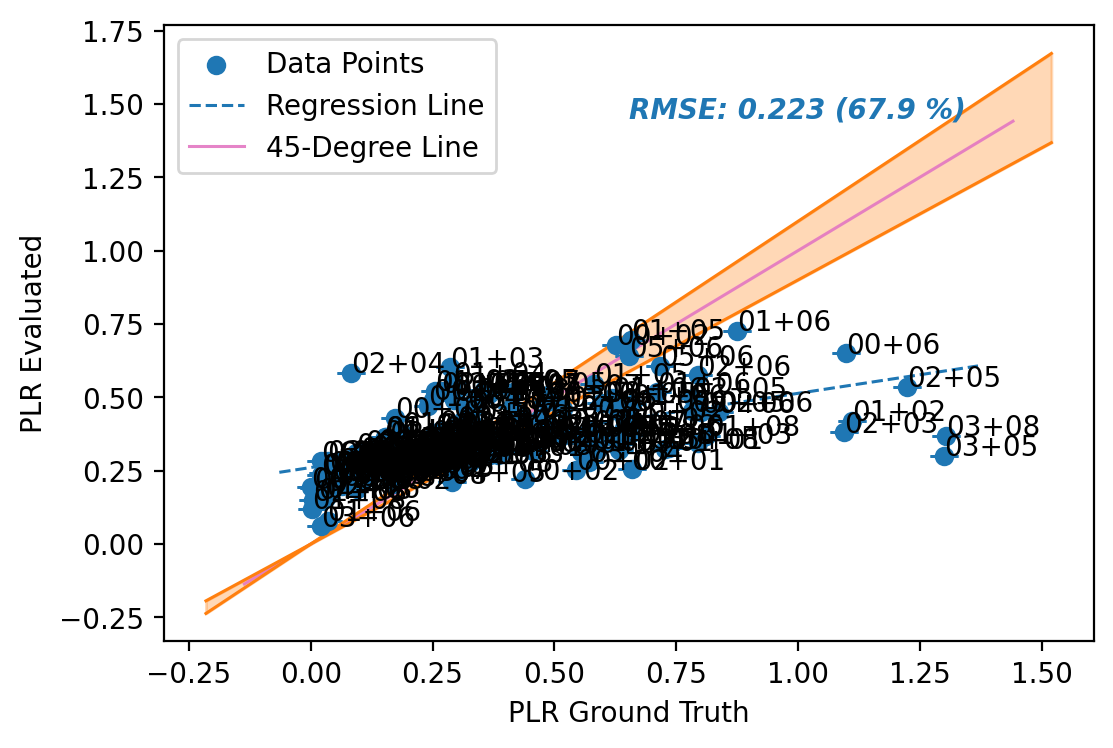

In [7]:
eval = DEval(filepaths, model_name='A', model_suffix=suffix, sr_model_id=sr_model_id, dr_model_id=dr_model_id)
eval.run_hist_method(N=1)
eval.plot('A')